# Analysis of centos positioning in Arab Andalusian Music

### 1. Setup

In [4]:
import music21
from music21 import *
import json
import os
import pandas as pd
from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import extract_score_data as esd
import score_data_processing as sdp
import seg2_score_data_processing as sdp2
import plotting as plot
import statistics_tests as stats
import seg2_statistics_tests as stats2

In [6]:
'''
Define paths to folders and files
Define constants
'''

DATA_FILE = 'data/arab-andalusian-scores-lines.json'
FOLDER_PATH = 'data/scores'
SCORES_FOLDER = os.listdir(FOLDER_PATH)
PLOTS_PATH = 'plots'

AMIN_CHACHOO_CENTOS = [['A', 'G', 'F', 'E'], ['B-', 'A', 'G'], ['B', 'D', 'C'], ['C', 'B', 'A', 'G'], ['E', 'F', 'G'], ['F', 'G', 'E', 'F', 'E', 'D', 'C'], ['G', 'A', 'B', 'C']]
TF_IDF_CENTOS = [['G', 'F', 'E'], ['E', 'F', 'G'], ['A', 'G', 'F'], ['F', 'E', 'D'], ['E', 'D', 'C'], ['F', 'E', 'D', 'C'], ['A', 'G', 'F', 'E']]
SIA_CENTOS = [['A', 'G', 'F'], ['D', 'C', 'B'], ['E', 'D', 'C'], ['E', 'E', 'F'], ['E', 'F', 'E'], ['E', 'F', 'G'], ['F', 'E', 'D'], ['F', 'E', 'F']]
MGDP_CENTOS = [['G', 'E', 'F'], ['F', 'G', 'E'], ['B-', 'A', 'G']]

CENTOS_LIST_NAMES = ['Amin Chachoo centos ', 'TF IDF centos ', 'SIA centos ', 'MGPD centos ']

In [7]:
 # Load the JSON data
with open(DATA_FILE, 'r') as json_file:
    data_annotations = json.load(json_file)

### 2. Get data from JSON annotations and prepare it for analysis

In [8]:
'''
Get scores data in a well structured data structure.
'''
scores_data = esd.get_score_data(SCORES_FOLDER, FOLDER_PATH, data_annotations)

In [9]:
'''
UNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES DATA STRUCTURE
'''
# scores_data

'\nUNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES DATA STRUCTURE\n'

In [10]:
'''
Add the corresponding music streams into the data structure.
'''
scores_data = esd.add_streams_to_score_data(scores_data)

In [11]:
''' 
Sanity check how many scores are counted within the JSON (should be 5)
'''
len(scores_data) == 5

True

In [ ]:
# sanity check that score parsing worked
scores_data['a451a7fc-c53f-462a-b3fc-4377bb588105']['annotations'][1]['ṣanā`i`'][0]['lines'][0]['sections'][0]['score'].show()

In [13]:
'''
UNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES DATA STRUCTURE
'''

# scores_data

'\nUNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES DATA STRUCTURE\n'

You can now see that the equivalent music streams have been added to each sanai and its sections.

In [14]:
# extract full sanai information and sanai scores
all_sanai, all_sanai_scores, all_sanai_lines_scores = esd.process_annotations(scores_data)     

In [15]:
'''
Testing that the parsing of the created data strcuture works by counting the occurrence of sanai, sana, 
lines and sections by getting the count of score sections for each piece of music in the provided scores data.
'''

score_section_counts = esd.calculate_score_section_counts(scores_data)

In [16]:
'''
UNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES SECTION COUNT DATA STRUCTURE
'''
# score_section_counts

'\nUNCOMMENT LINE BELOW IF WANT TO CHECK THE SCORES SECTION COUNT DATA STRUCTURE\n'

### 3. Count centos positions for all sections of sanai and lines of all data for various centos lists

In [17]:
# NOTE FROM SUVI: how would we feel aobut changing the name of scores in this context to e.g. data_set? As the full dict with all the scores is our 'data set' for the project
# also might make it a bit clearer like datat set vs the scores in the context of the other functions 
# NOTE FROM ISABELLE: Yes, this makes sense. Do you want to change scores_data to data_set? 

'''
Extracting the centos counts of the different key centos of ṭab‘ al-māya identified by Nuttall et. als paper
'''
pattern_counter_3 = sdp.count_pattern_in_score # firs 25%, midle 50%, last 25%
pattern_counter_10 = sdp2.count_pattern_in_score # in increments of 10%

# counts per sections of sanai and lines
all_amin_chachoo_centos_counts_3 = sdp.count_all_patterns_wrapper(scores_data, AMIN_CHACHOO_CENTOS, pattern_counter_3)
all_amin_chachoo_centos_counts_10 = sdp.count_all_patterns_wrapper(scores_data, AMIN_CHACHOO_CENTOS, pattern_counter_10)

all_tf_idf_centos_counts_3 = sdp.count_all_patterns_wrapper(scores_data, TF_IDF_CENTOS, pattern_counter_3)
all_tf_idf_centos_counts_10 = sdp.count_all_patterns_wrapper(scores_data, TF_IDF_CENTOS, pattern_counter_10)

all_sia_centos_counts_3 = sdp.count_all_patterns_wrapper(scores_data, SIA_CENTOS, pattern_counter_3)
all_sia_centos_counts_10 = sdp.count_all_patterns_wrapper(scores_data, SIA_CENTOS, pattern_counter_10)

all_mgdp_centos_counts_3 = sdp.count_all_patterns_wrapper(scores_data, MGDP_CENTOS, pattern_counter_3)
all_mgdp_centos_counts_10 = sdp.count_all_patterns_wrapper(scores_data, MGDP_CENTOS, pattern_counter_10)

In [18]:
'''
UNCOMMENT LINE BELOW IF WANT TO CHECK THE CENTOS COUNT DATA STRUCTURE
'''
# all_sia_centos_counts_10

'\nUNCOMMENT LINE BELOW IF WANT TO CHECK THE CENTOS COUNT DATA STRUCTURE\n'

In [19]:
# testing that the count_pattern_in_score function works as intended
first_sana = all_sanai_scores[0]
example_cento = AMIN_CHACHOO_CENTOS[0]
pattern_counts_3 = sdp.count_pattern_in_score(first_sana, example_cento)
pattern_counts_10 = sdp2.count_pattern_in_score(first_sana, example_cento)

In [21]:
'''
UNCOMMENT LINE BELOW IF WANT TO CHECK THE PATTERN COUNTS DATA STRUCTURE
'''
#pattern_counts_10, pattern_counts_3

'\nUNCOMMENT LINE BELOW IF WANT TO CHECK THE PATTERN COUNTS DATA STRUCTURE\n'

### 4. Count centos positions for all sanai and lines of all data for various centos lists for each score

In [22]:
'''
Count the cumulative distribution of centos for different sanai of the different scores.
'''
# Get the mizans for each file in the dataset (for naming plots)
scores_mizans_dict = esd.get_mizans_of_scores(scores_data)

# Get centos counts
centos_counts_3 = [all_amin_chachoo_centos_counts_3, all_tf_idf_centos_counts_3, all_sia_centos_counts_3, all_mgdp_centos_counts_3]
centos_counts_10 = [all_amin_chachoo_centos_counts_10, all_tf_idf_centos_counts_10, all_sia_centos_counts_10, all_mgdp_centos_counts_10]

centos_positions_counter_3 = sdp.count_centos_positions
centos_positions_counter_10 = sdp2.count_centos_positions

cumulative_sanai_centos_positions_per_score_3, cumulative_line_centos_positions_per_score_3 = sdp.get_centos_counts_per_tab_mizan_score(centos_counts_3, scores_mizans_dict, \
                                                                                                                                        centos_positions_counter_3)
cumulative_sanai_centos_positions_per_score_10, cumulative_line_centos_positions_per_score_10 = sdp.get_centos_counts_per_tab_mizan_score(centos_counts_10, scores_mizans_dict, \
                                                                                                                                          centos_positions_counter_10)


In [24]:
'''
PlDisplay the overall distribution of the centos in each centos list as tables.

Modify the value of flags below if you wish to view specific tables.
DISPLAY_TAB_MIZAN_LEVEL_COUNT_TABLES: allows analysis of how distribution changes over mizans
DISPLAY_CENTOS_LEVEL_COUNT_TABLES: allows easier analysis of how distribution varies between centos lists
'''

DISPLAY_TAB_MIZAN_LEVEL_COUNT_TABLES = False
DISPLAY_CENTOS_LEVEL_COUNT_TABLES = False

In [25]:
if DISPLAY_TAB_MIZAN_LEVEL_COUNT_TABLES:
    print('DIVIDED INTO FIRST 25%, MIDDLE 50%, AND LAST 25%')
    print('SANAI LEVEL:')
    for centos_list in cumulative_sanai_centos_positions_per_score_3:
        print(centos_list)
        display(cumulative_sanai_centos_positions_per_score_3[centos_list].style)

    print('\nLINE LEVEL')
    for centos_list in cumulative_line_centos_positions_per_score_3:
        print(centos_list)
        display(cumulative_line_centos_positions_per_score_3[centos_list].style)

    print('DIVIDED INTO INCREMENTS OF 10%')
    print('SANAI LEVEL:')
    for centos_list in cumulative_sanai_centos_positions_per_score_10:
        print(centos_list)
        display(cumulative_sanai_centos_positions_per_score_10[centos_list].style)

    print('\nLINE LEVEL')
    for centos_list in cumulative_line_centos_positions_per_score_10:
        print(centos_list)
        display(cumulative_line_centos_positions_per_score_10[centos_list].style)


### 5. Count distribution by different centos lists (e.g. Amin Chachoo centos and TF IDF centos) across all the scores

In [26]:
sanai_distribution_per_centos_list_3 = sdp.count_distribution_over_dataset(cumulative_sanai_centos_positions_per_score_3)
lines_distribution_per_centos_list_3 = sdp.count_distribution_over_dataset(cumulative_line_centos_positions_per_score_3)

sanai_distribution_per_centos_list_10 = sdp.count_distribution_over_dataset(cumulative_sanai_centos_positions_per_score_10)
lines_distribution_per_centos_list_10 = sdp.count_distribution_over_dataset(cumulative_line_centos_positions_per_score_10)

In [27]:
if DISPLAY_CENTOS_LEVEL_COUNT_TABLES:
    print('DIVIDED INTO FIRST 25%, MIDDLE 50%, AND LAST 25%')
    print('SANAI LEVEL:')
    for centos_list in sanai_distribution_per_centos_list_3:
        print(centos_list)
        display(sanai_distribution_per_centos_list_3[centos_list].style)

    print('\nLINE LEVEL')
    for centos_list in lines_distribution_per_centos_list_3:
        print(centos_list)
        display(lines_distribution_per_centos_list_3[centos_list].style)

    print('DIVIDED INTO INCREMENTS OF 10%')
    print('SANAI LEVEL:')
    for centos_list in sanai_distribution_per_centos_list_10:
        print(centos_list)
        display(sanai_distribution_per_centos_list_10[centos_list].style)

    print('\nLINE LEVEL')
    for centos_list in lines_distribution_per_centos_list_10:
        print(centos_list)
        display(lines_distribution_per_centos_list_10[centos_list].style)

### 6. Calculate normalized position counts throughout entire dataset: all centos, all centos lists 

In [28]:
sanai_combined_3 = sdp.combine_normalized_position_counts(sanai_distribution_per_centos_list_3)
lines_combined_3 = sdp.combine_normalized_position_counts(lines_distribution_per_centos_list_3)

sanai_combined_10 = sdp2.combine_normalized_position_counts(sanai_distribution_per_centos_list_10)
lines_combined_10 = sdp2.combine_normalized_position_counts(lines_distribution_per_centos_list_10)

### 7. Plot the overall distribution of the centos in each centos list. 

In [29]:
'''
Plot the overall distribution of the centos in each centos list.

Modify the value of flags below if you wish to view specific graphs and if you wish to save graphs.
PLOT_DATA_DISTR_PER_SCORE_AND_CENTOS_LIST: plot all detail of different centos distribution for each score (5 scores in total)
                                           allows analysis of how distribution changes over mizans
PLOT_ALL_DATA_DISTR_PER_CENTOS_LIST: plot only the combined counts per centos list (combine data across scores)
                                     allows easier analysis of how distribution varies between centos lists
PLOT_OVERALL_TREND: plot overall trends for entire dataset (combine all centos, centos lists and normalize to visualise general trend)
                    allows easy visualisation of overall trend of centos positioning distribution over the entire dataset
SAVE_PLOTS: trigger whether plots are saved to a folder as well as shown in the notebook
'''

PLOT_DATA_DISTR_PER_SCORE_AND_CENTOS_LIST = False
PLOT_ALL_DATA_DISTR_PER_CENTOS_LIST = True
PLOT_OVERALL_TREND = True

SAVE_PLOTS = False

In [30]:
#plot distribution withi each score and centos lists 

if PLOT_DATA_DISTR_PER_SCORE_AND_CENTOS_LIST == True:

    print('DIVIDED INTO FIRST 25%, MIDDLE 50%, AND LAST 25%')
    print("SANAI LEVEL:")
    for centos_list in cumulative_sanai_centos_positions_per_score_3:
        print(centos_list)
        plot.plot_centos_distribution(cumulative_sanai_centos_positions_per_score_3[centos_list], centos_list)

    print("LINE LEVEL:")
    for centos_list in cumulative_line_centos_positions_per_score_3:
        print(centos_list)
        plot.plot_centos_distribution(cumulative_line_centos_positions_per_score_3[centos_list], centos_list)

    print('DIVIDED INTO INCREMENTS OF 10%')
    print("SANAI LEVEL:")
    for centos_list in cumulative_sanai_centos_positions_per_score_10:
        print(centos_list)
        plot.plot_centos_distribution(cumulative_sanai_centos_positions_per_score_10[centos_list], centos_list)

    print("LINE LEVEL:")
    for centos_list in cumulative_line_centos_positions_per_score_10:
        print(centos_list)
        plot.plot_centos_distribution(cumulative_line_centos_positions_per_score_10[centos_list], centos_list)

DIVIDED INTO FIRST 25%, MIDDLE 50%, AND LAST 25%
SANAI LEVEL:


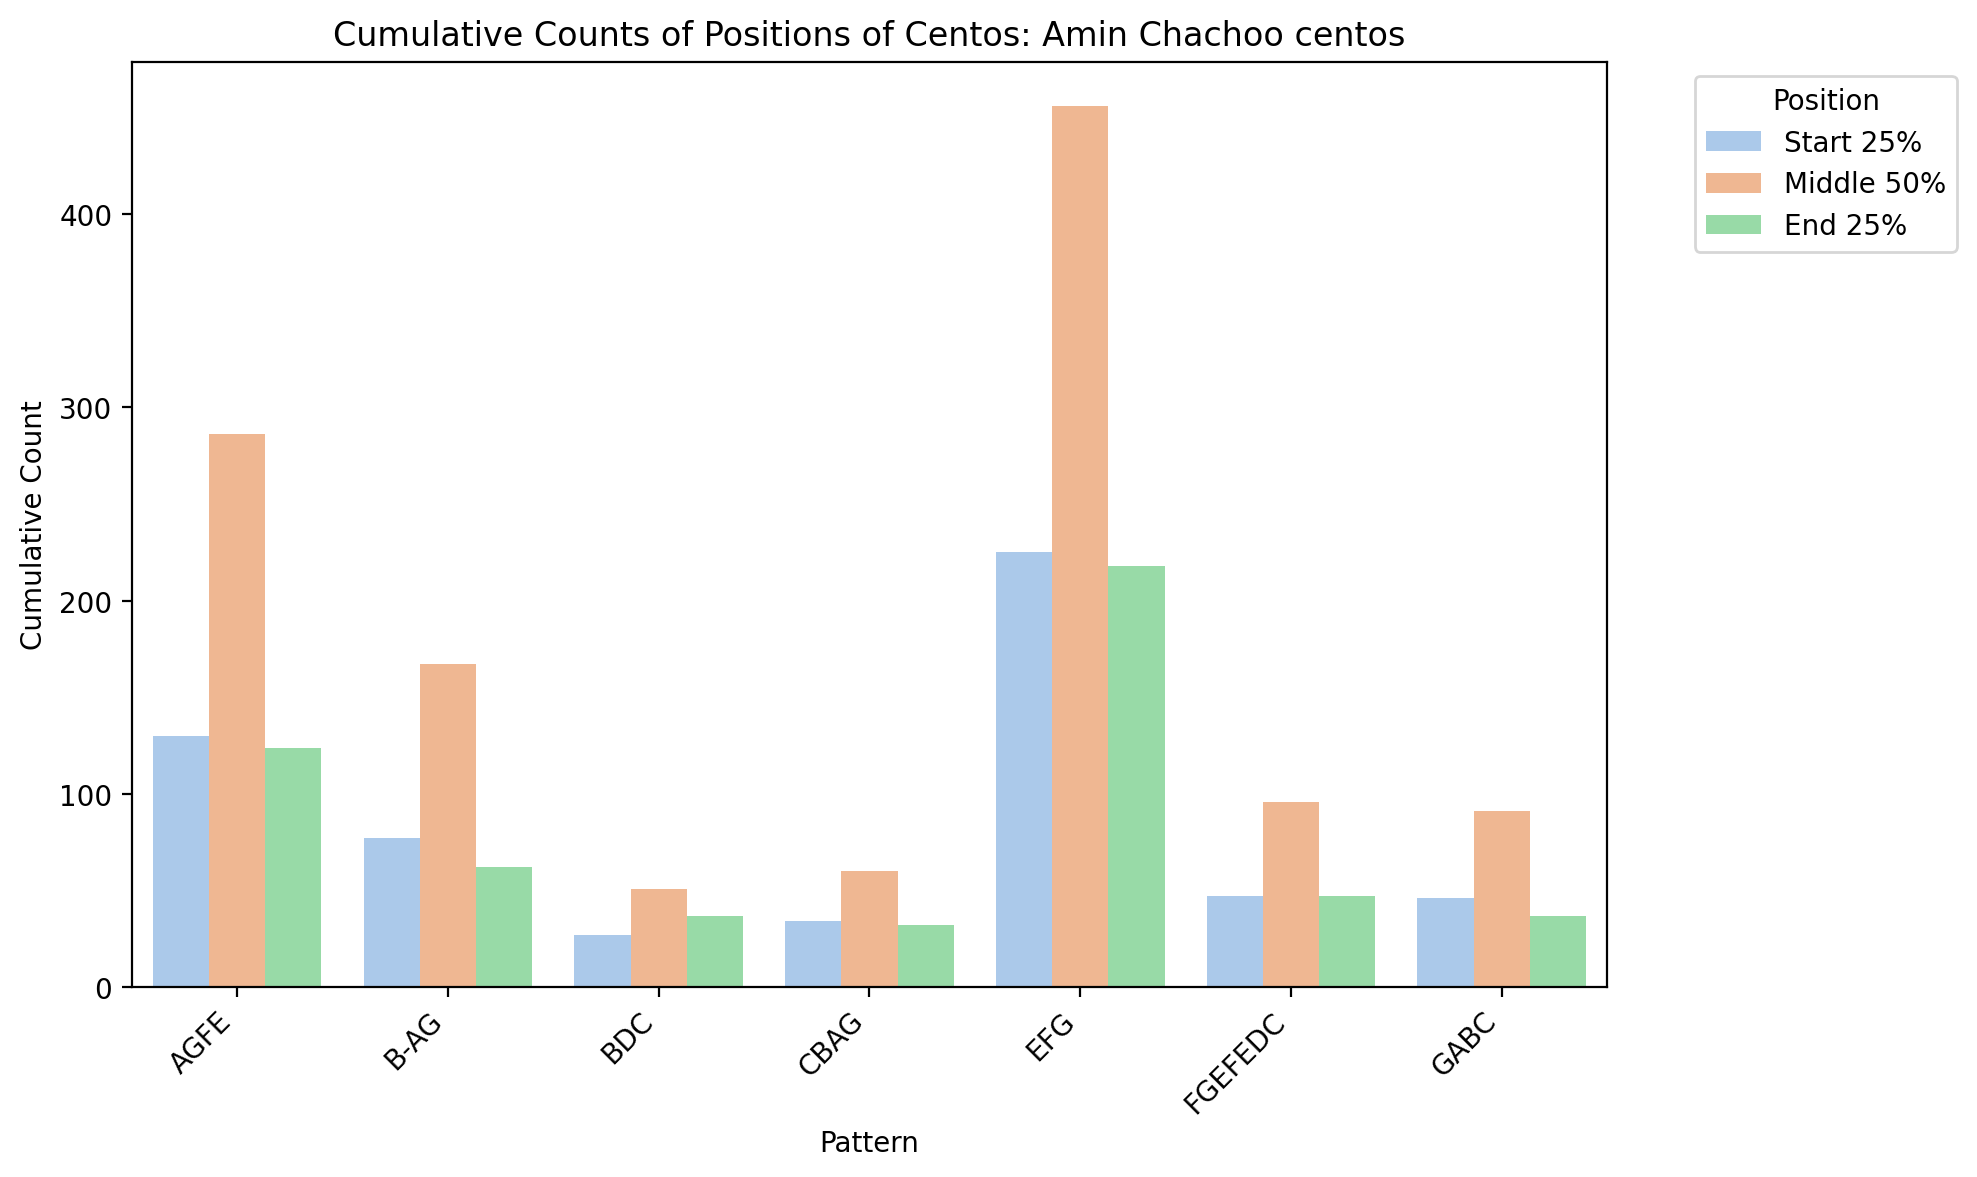

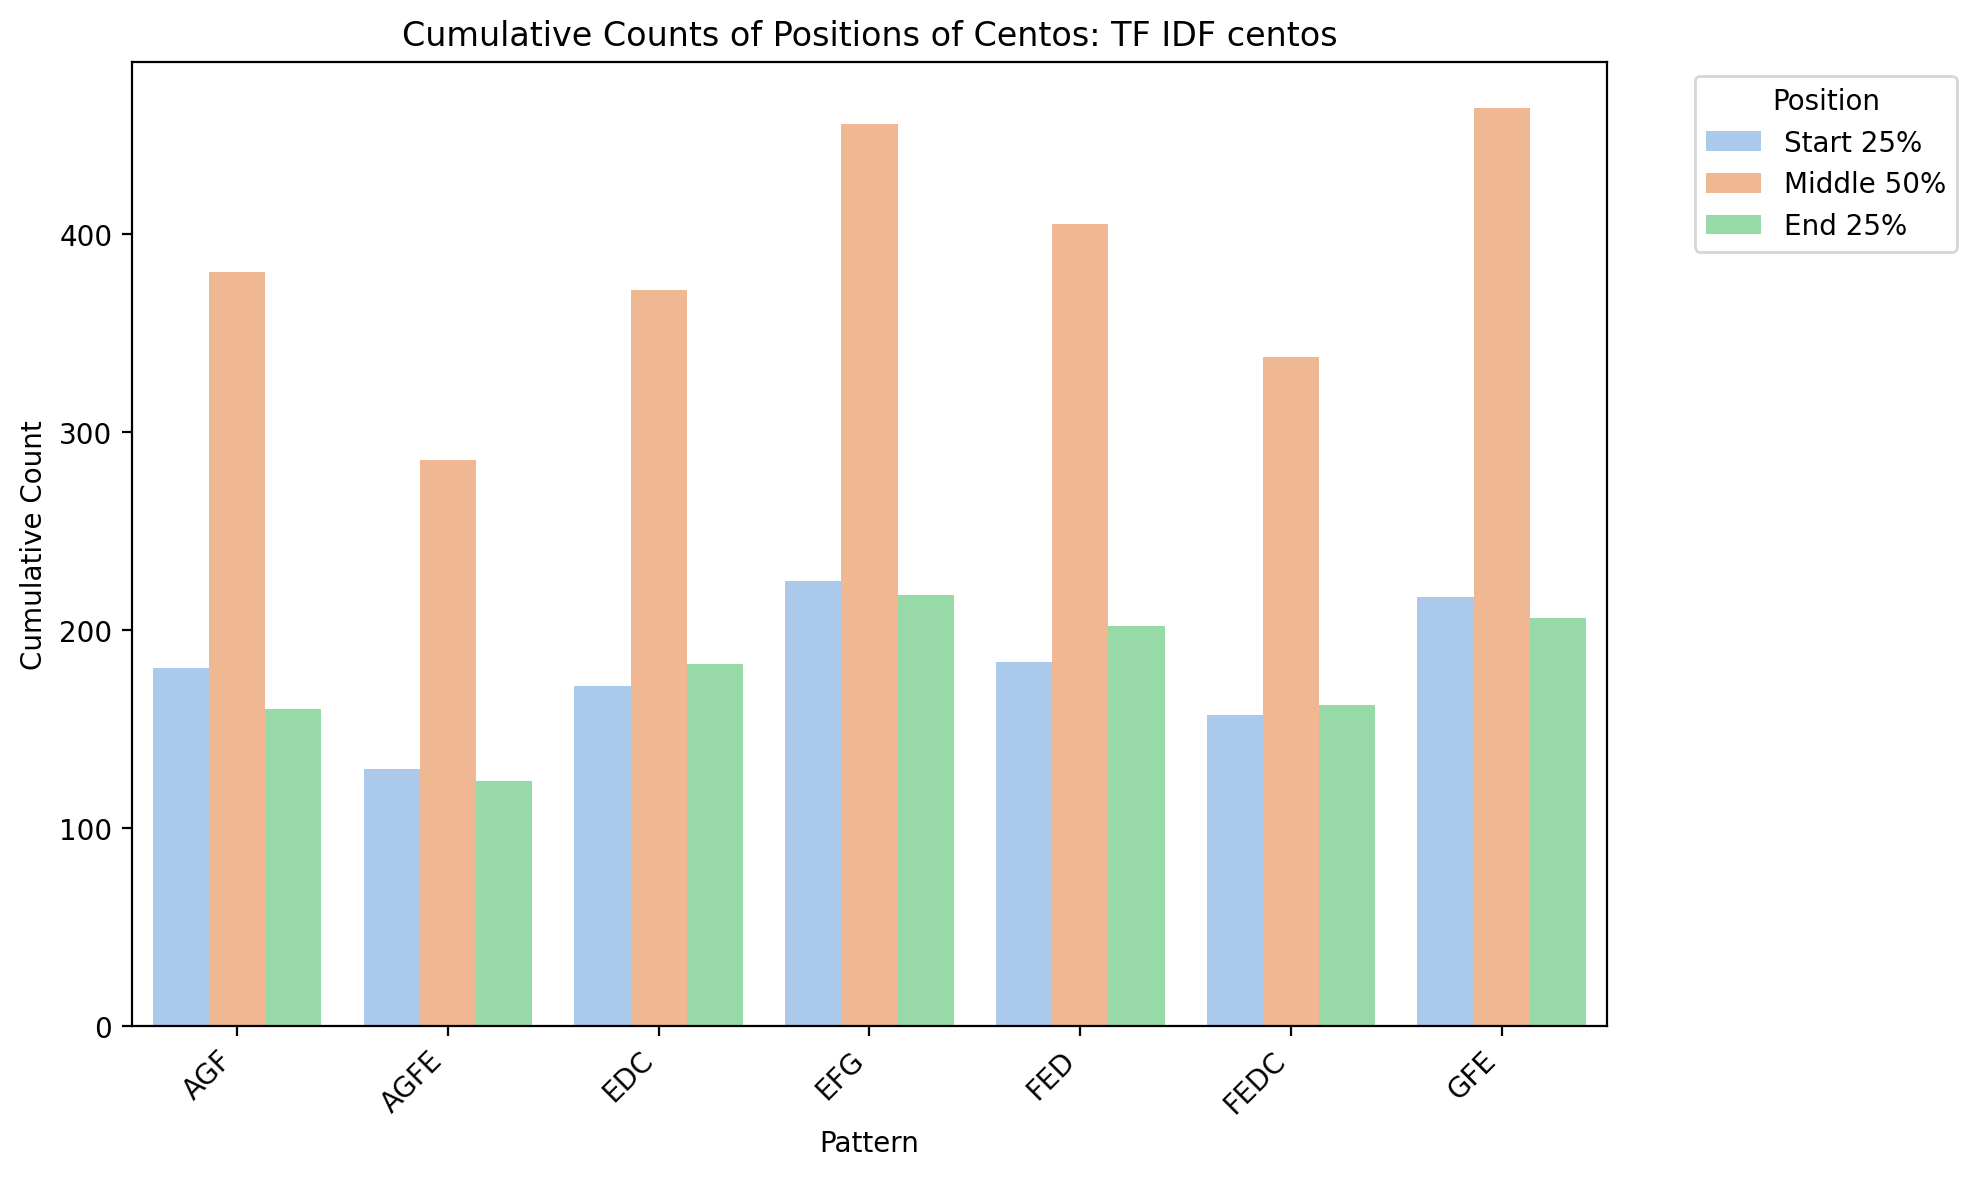

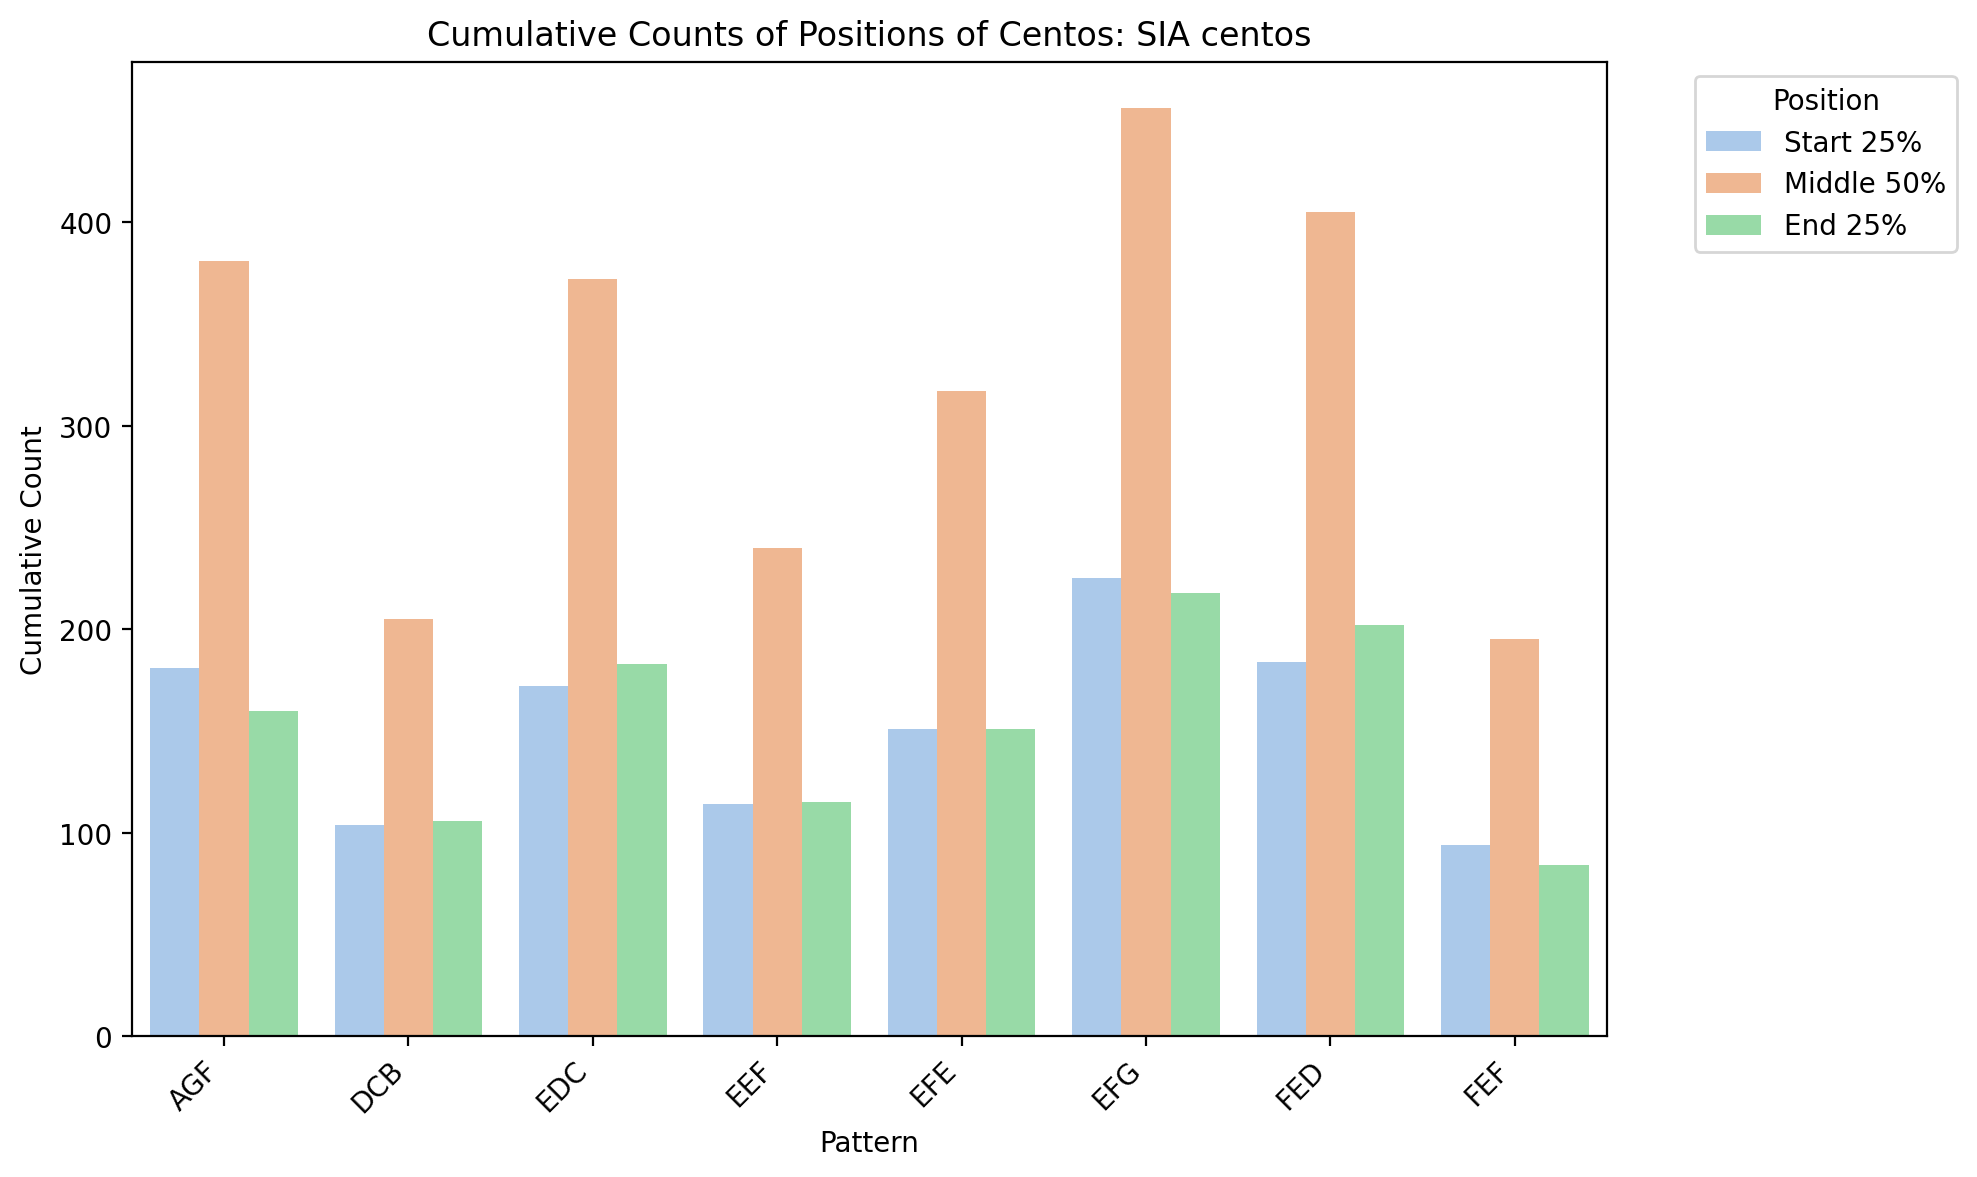

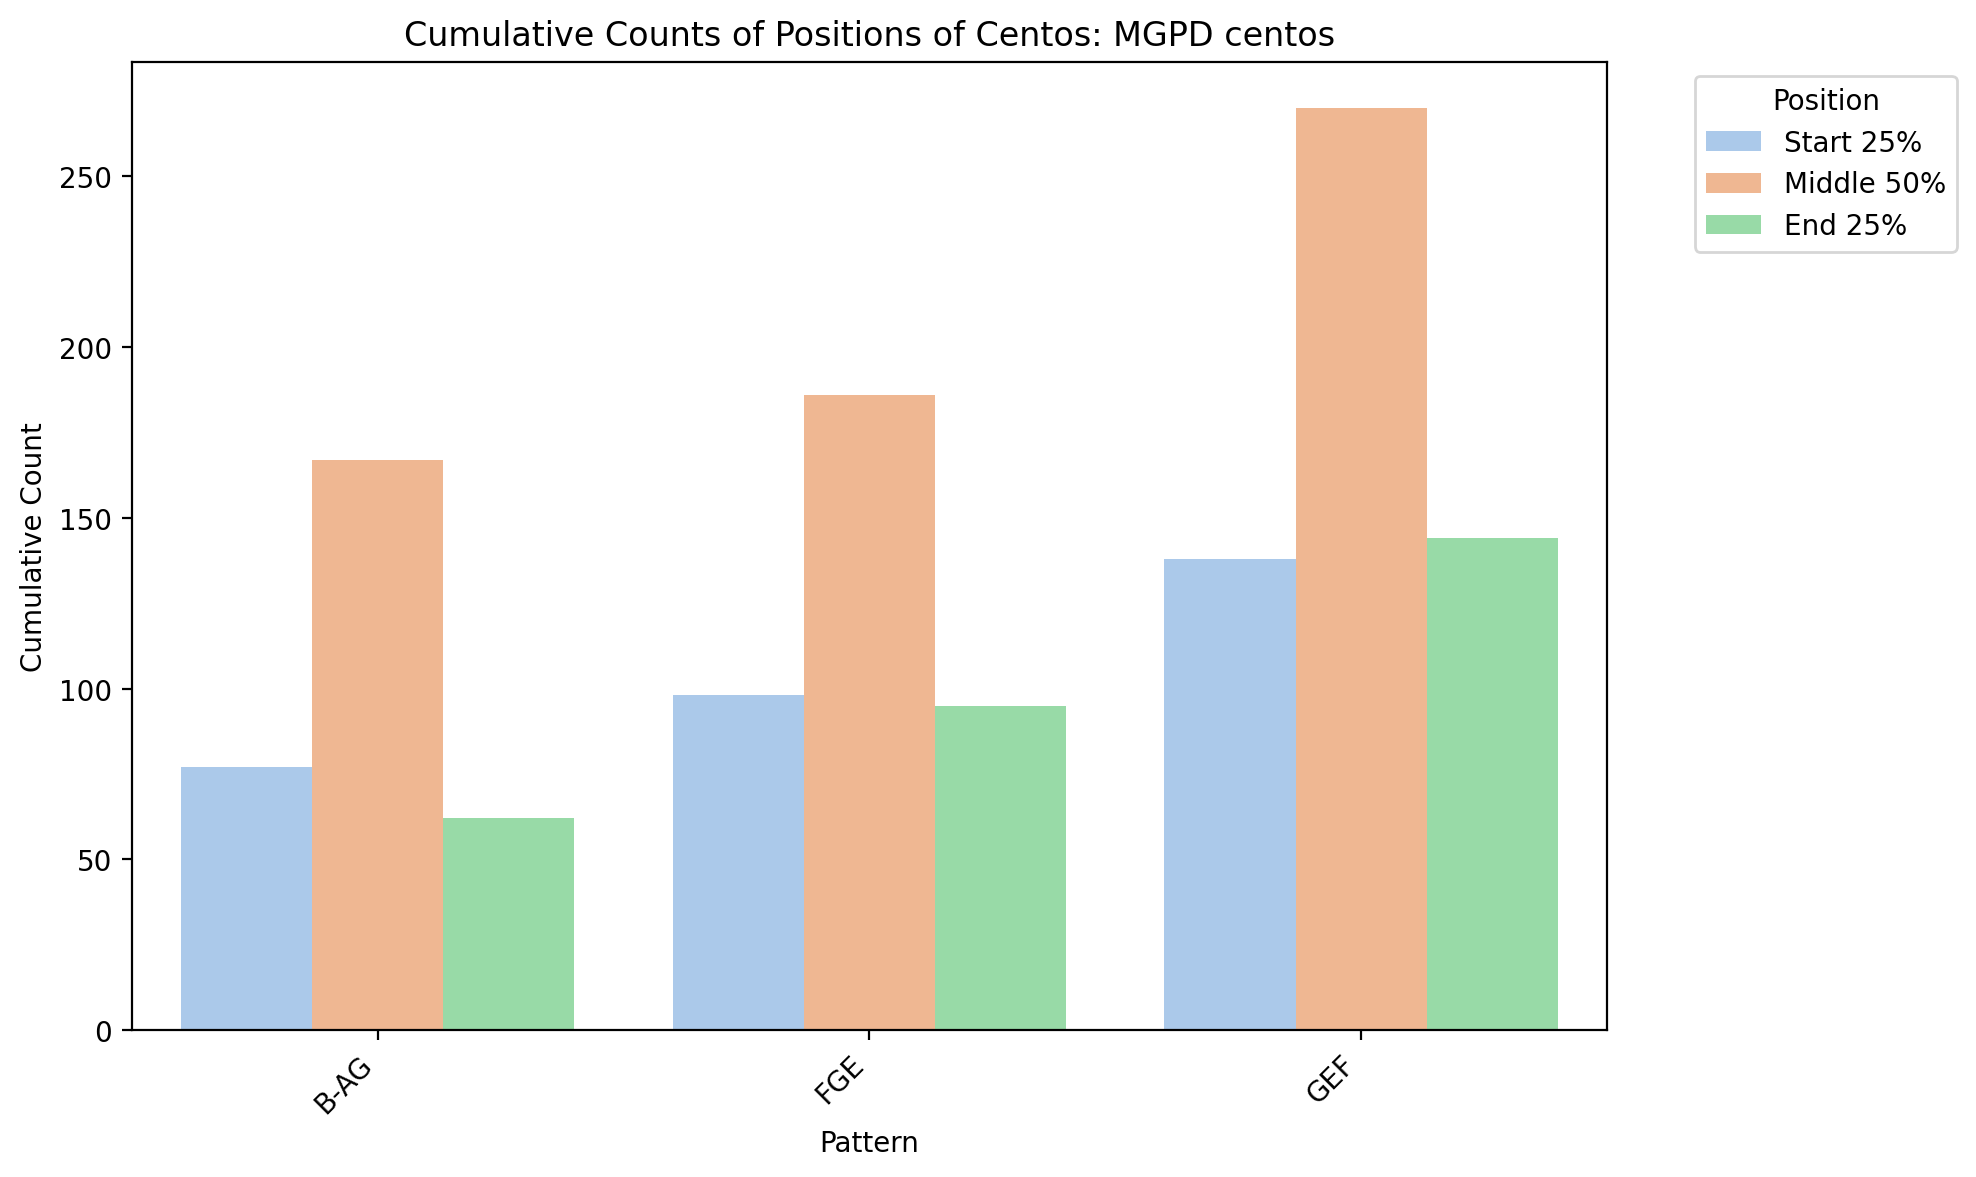

LINE LEVEL:


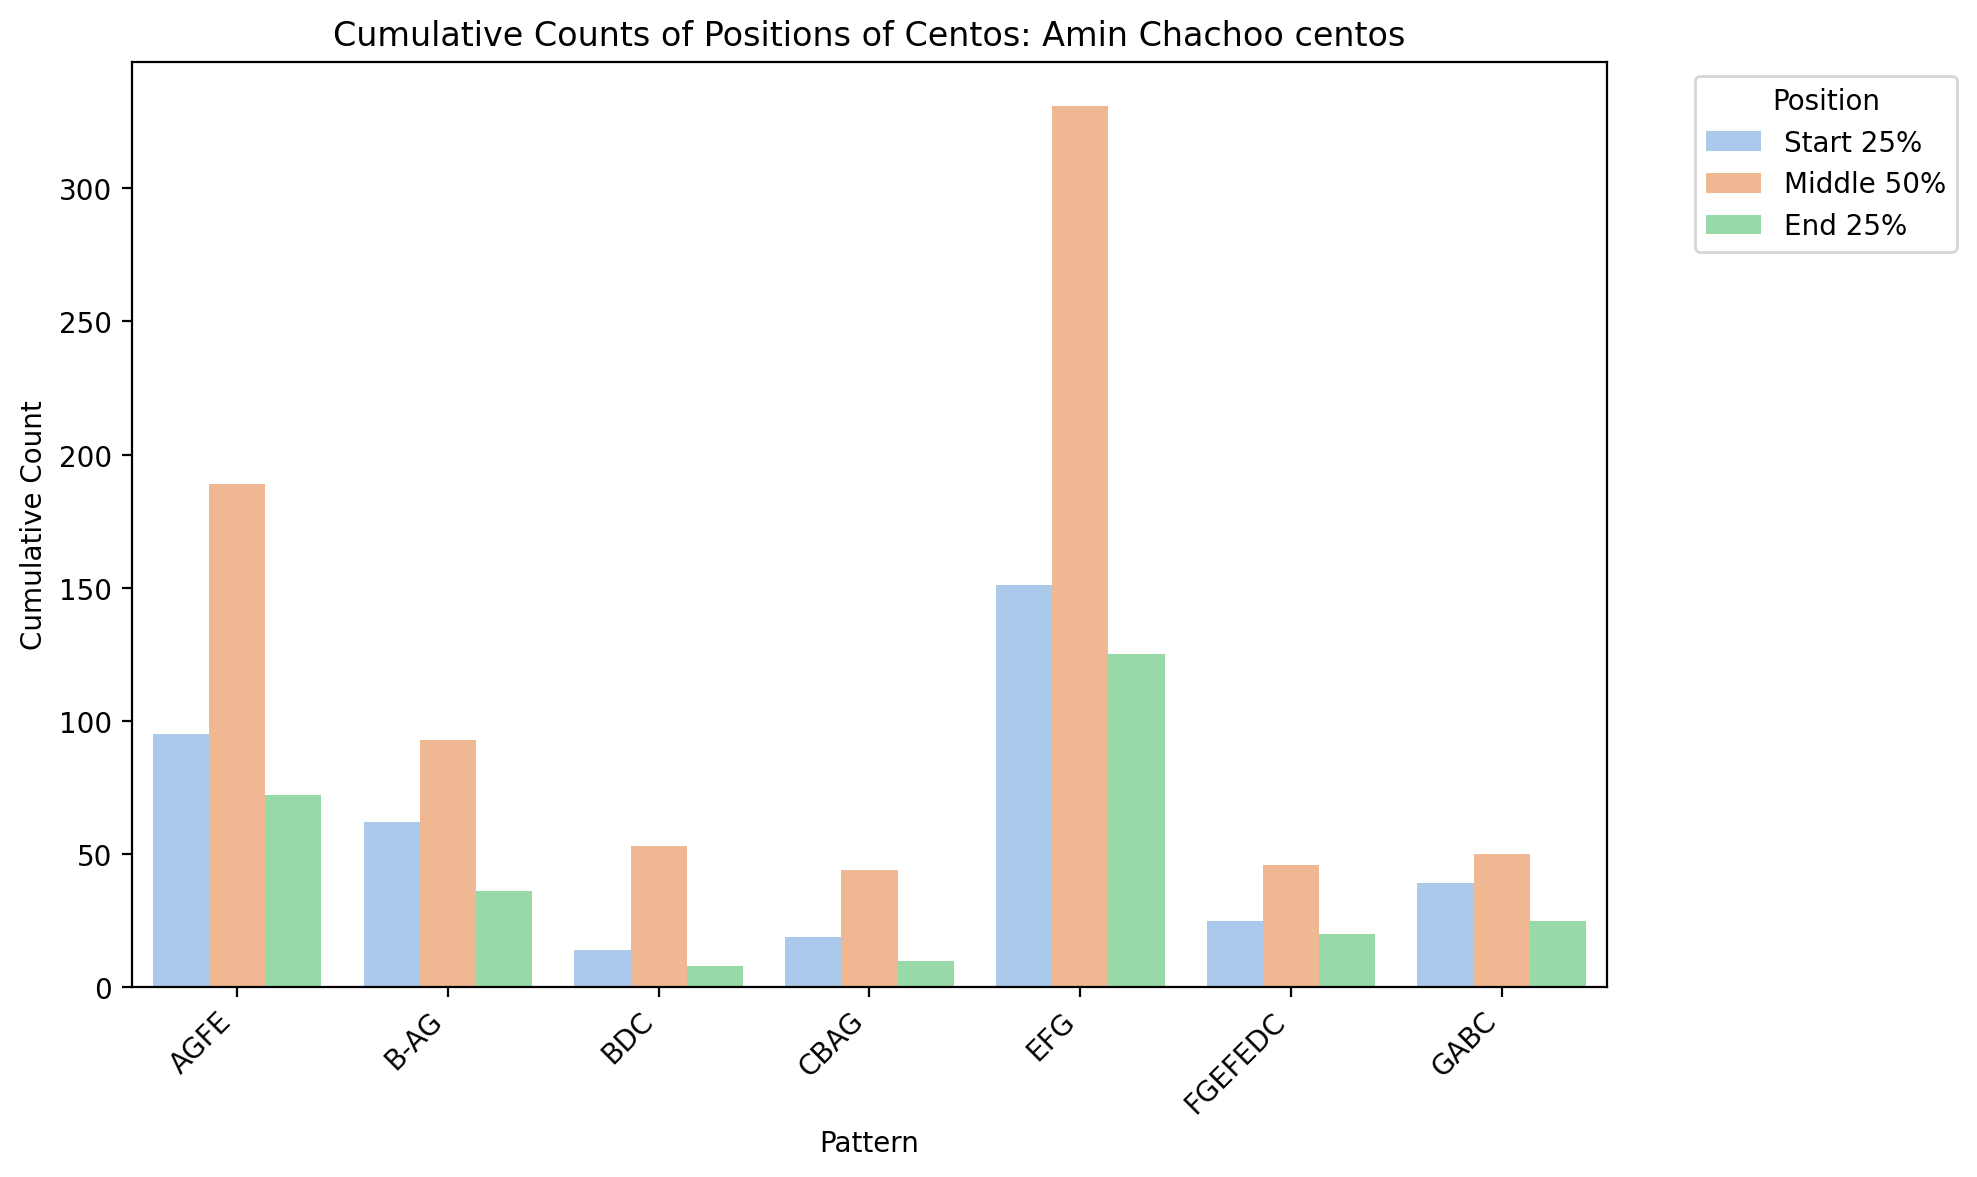

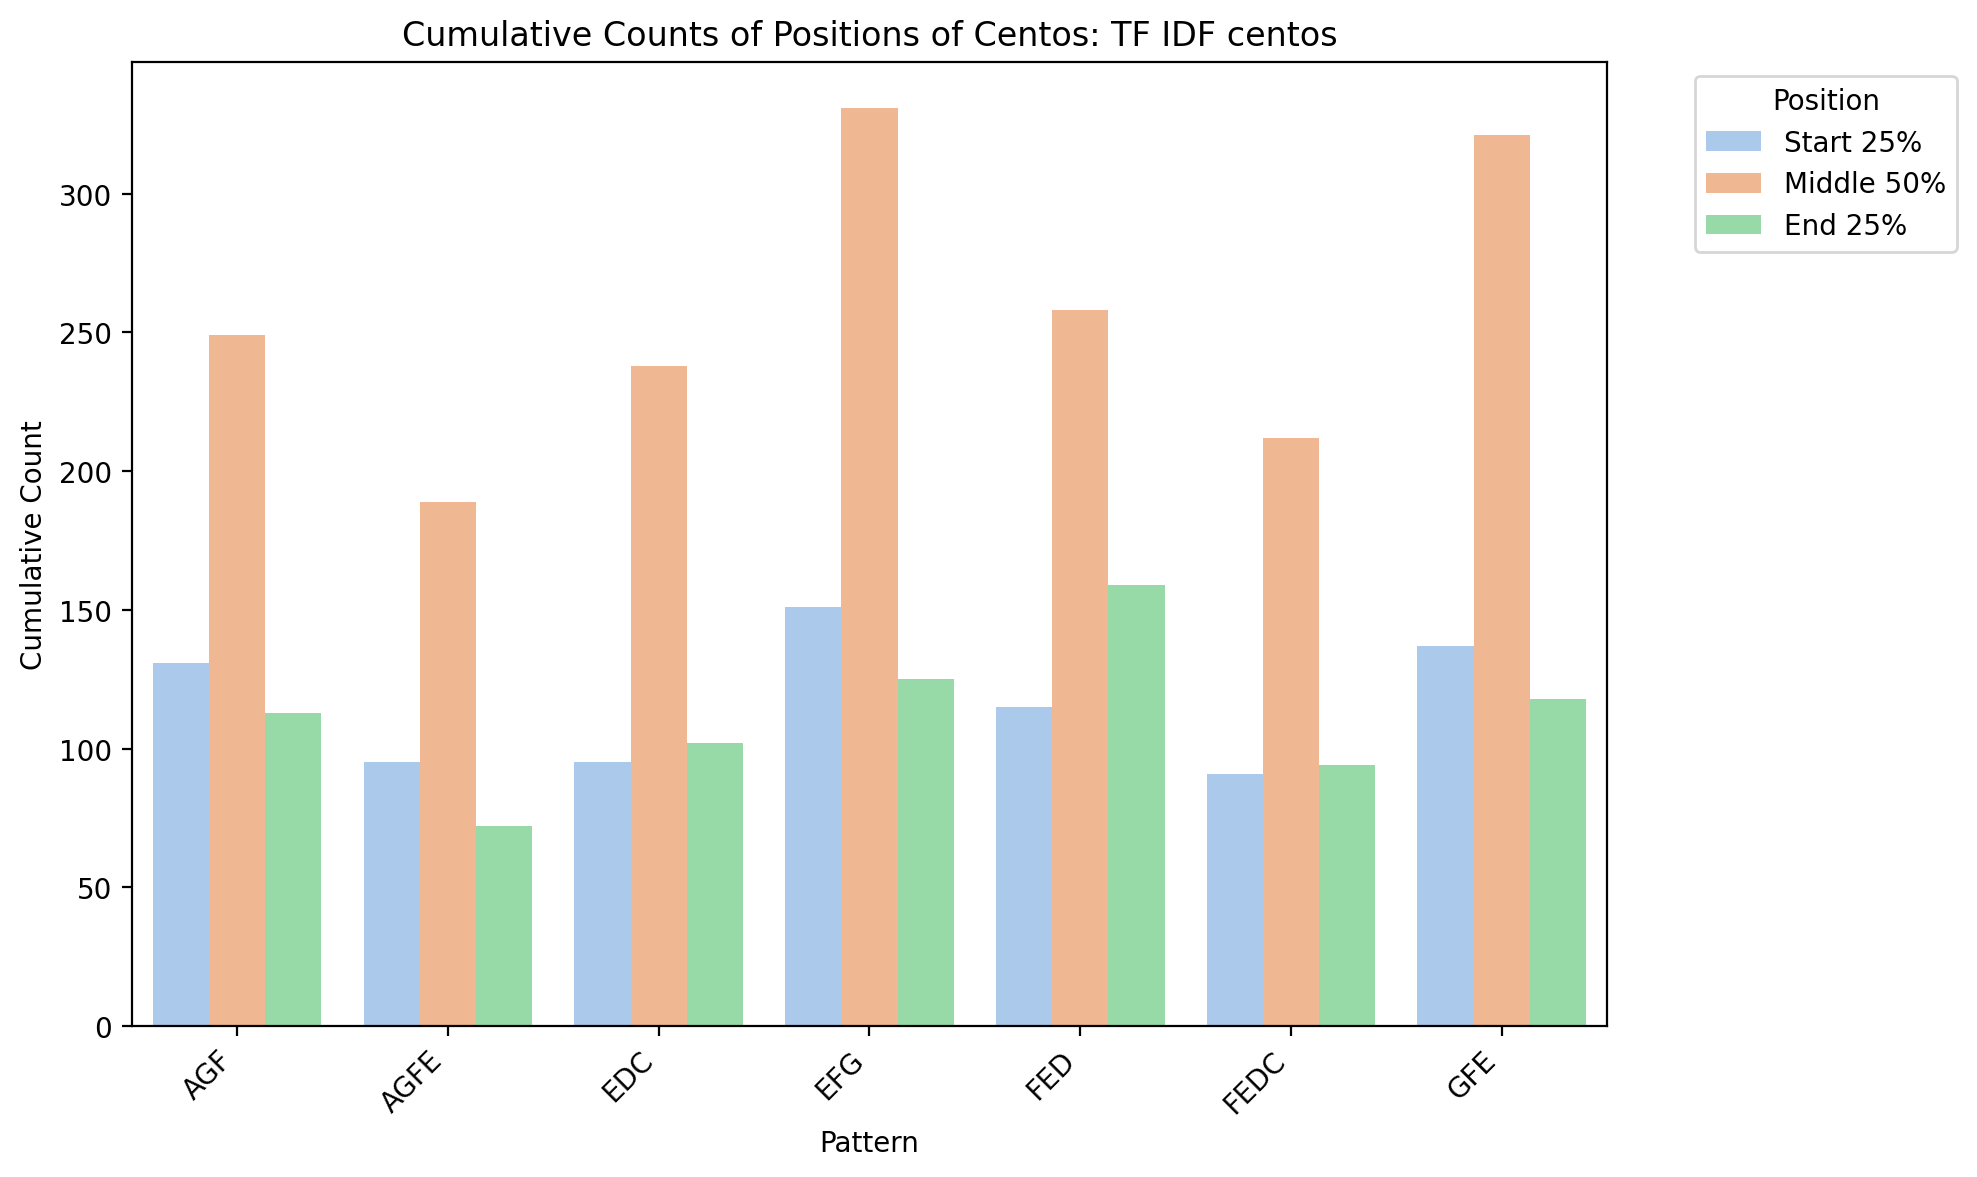

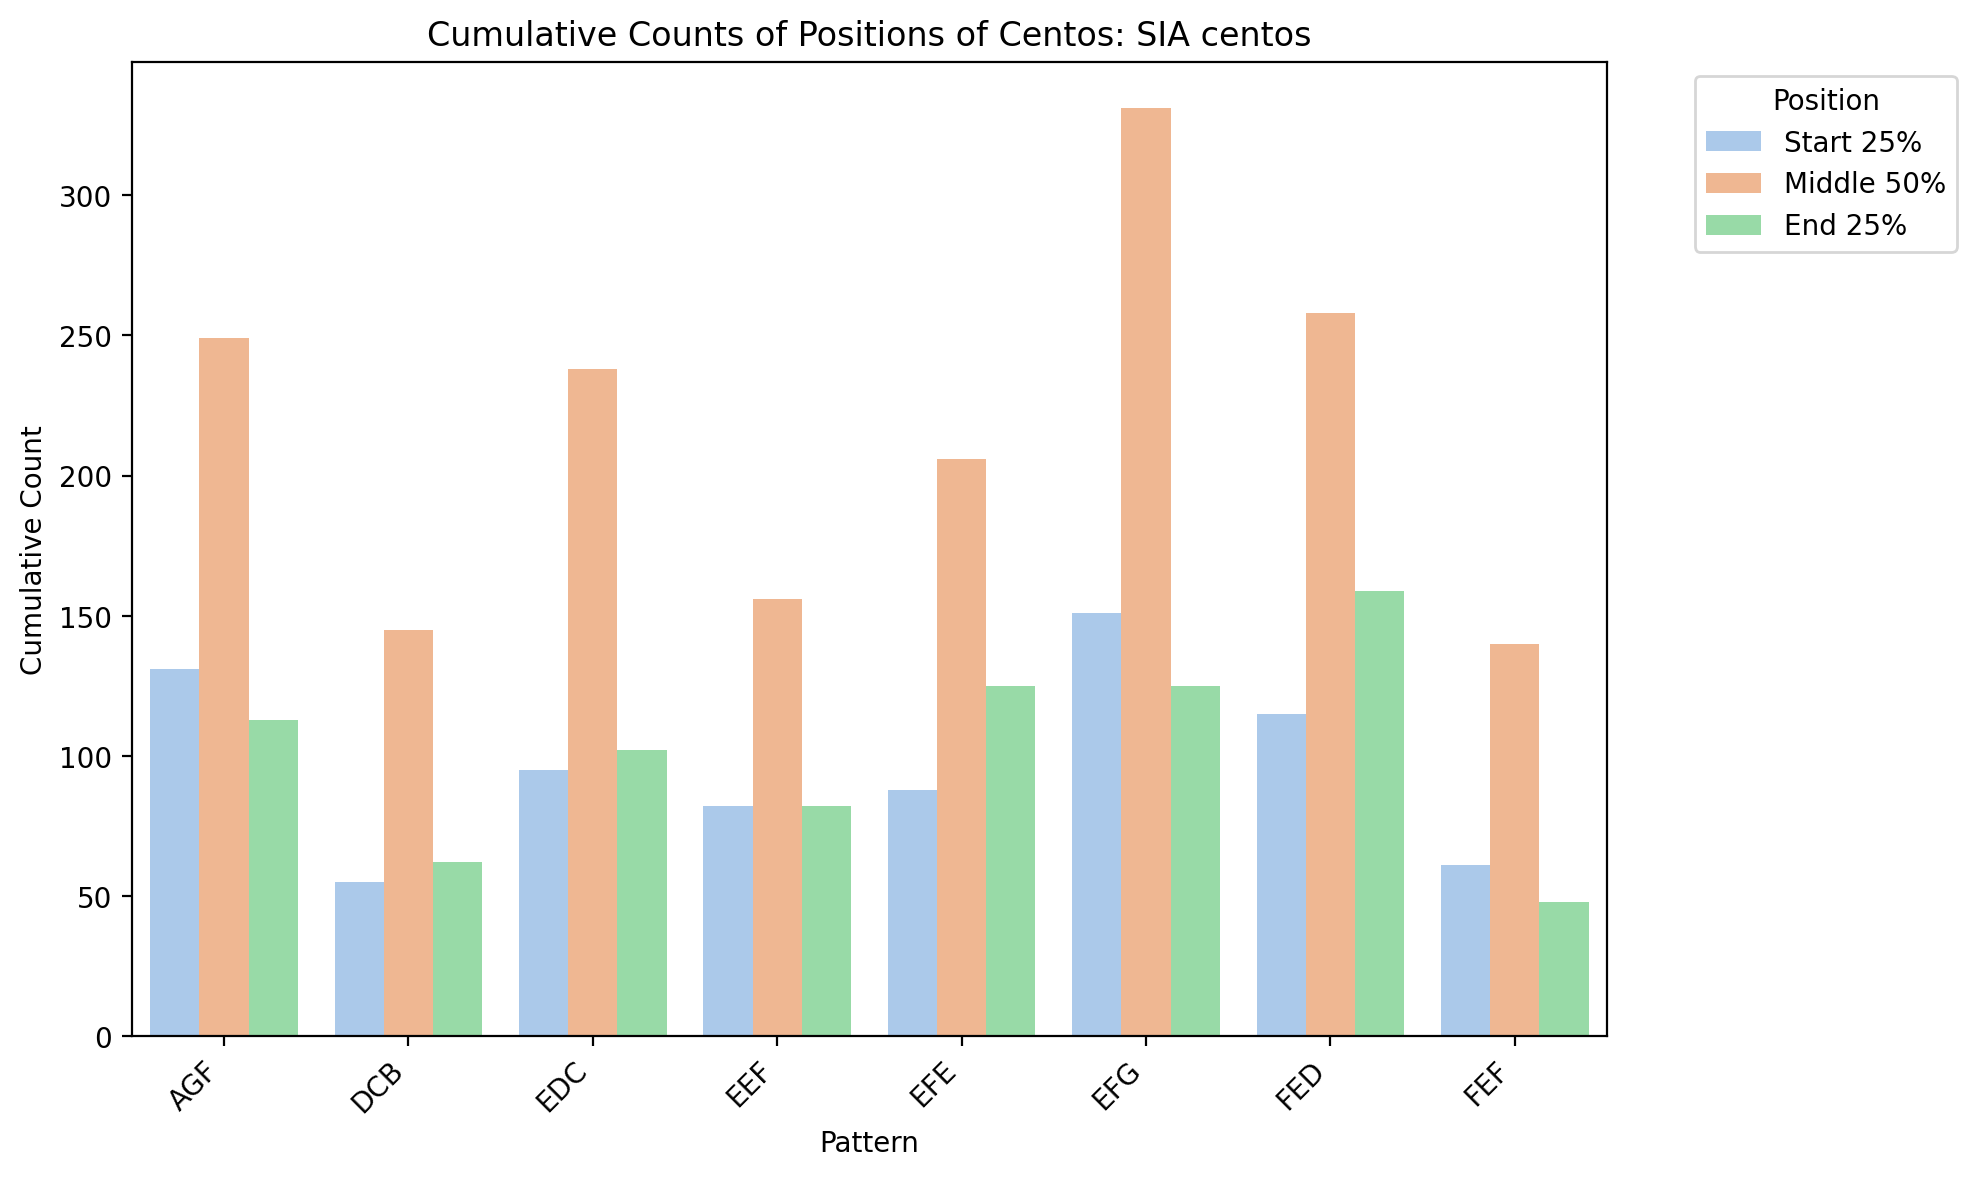

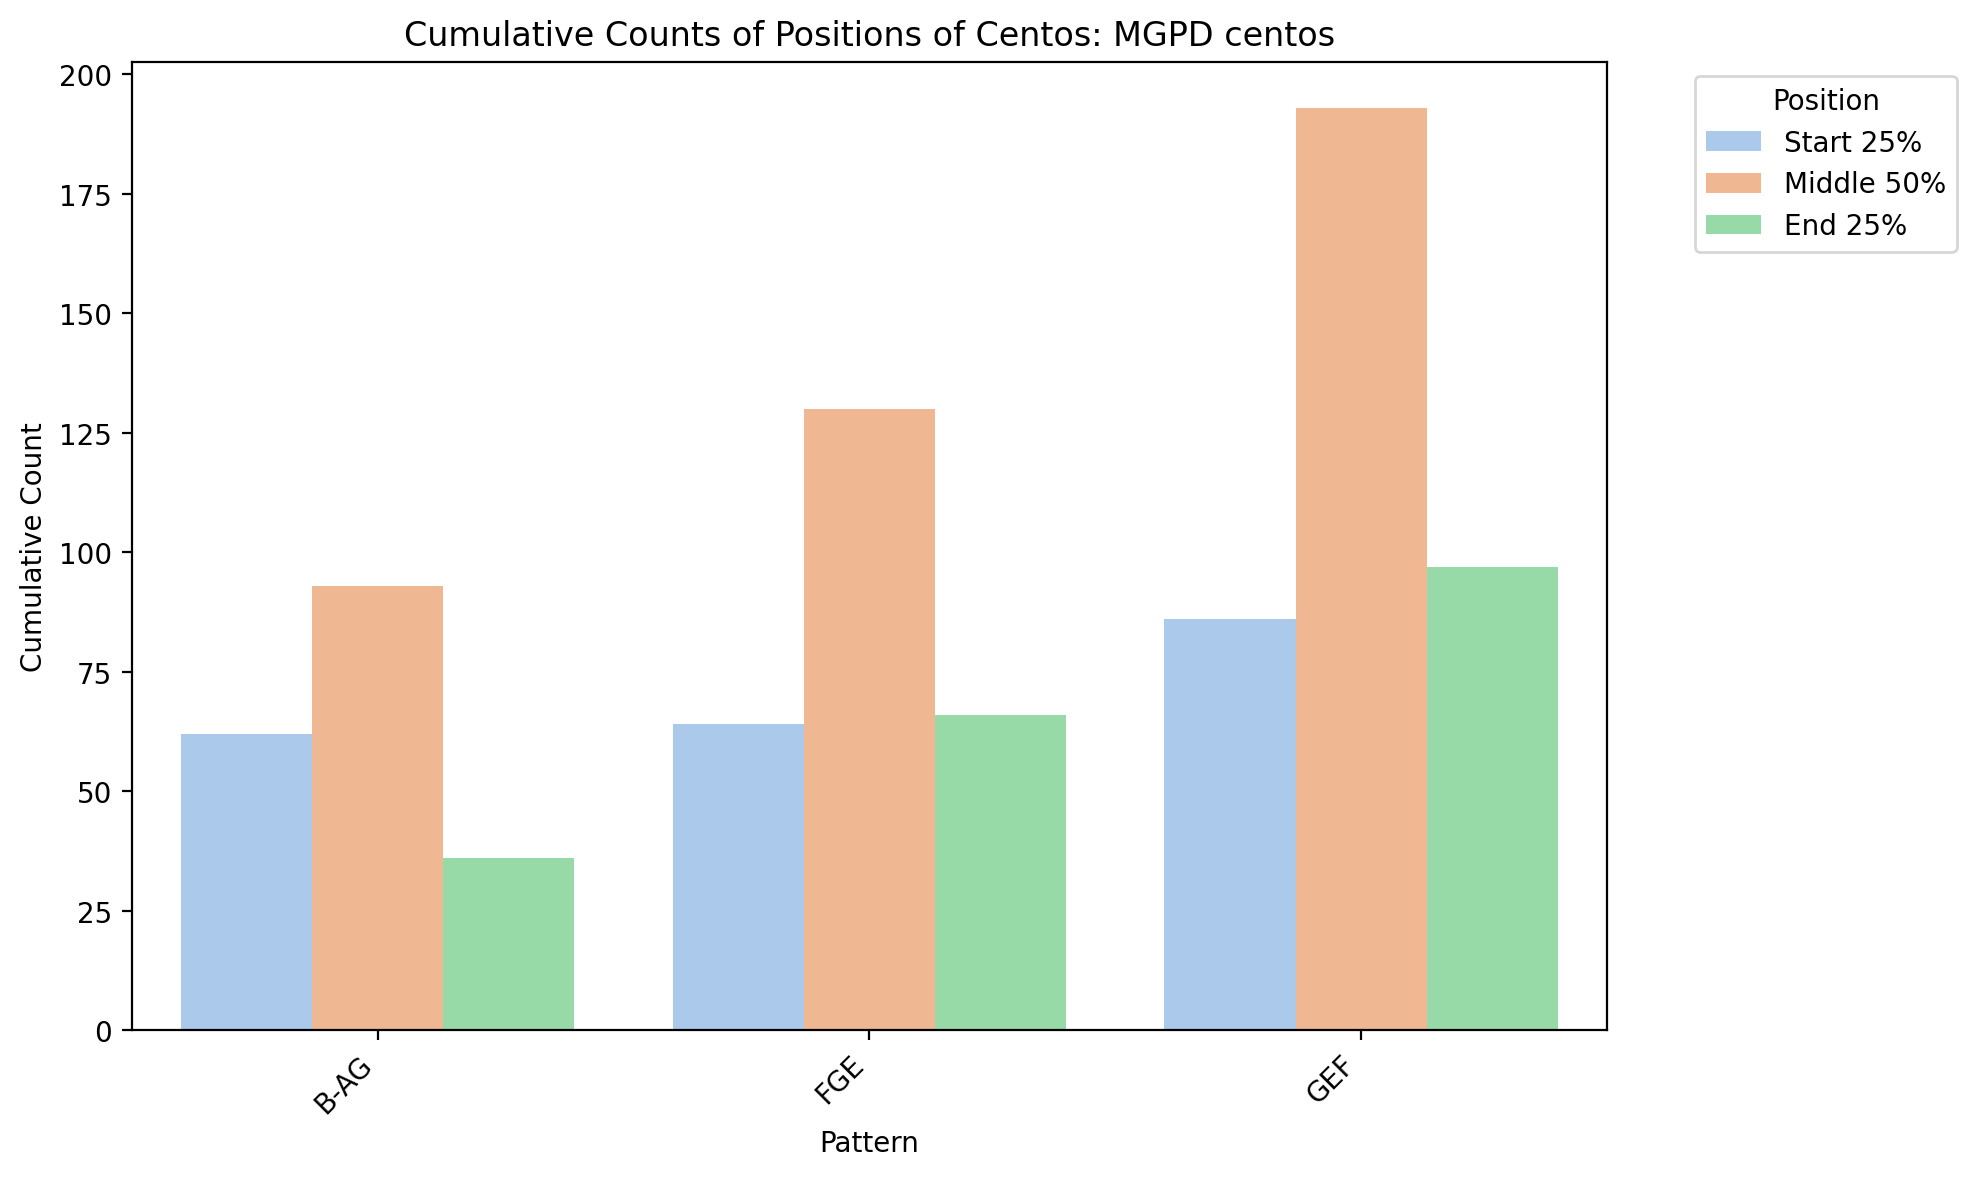

DIVIDED INTO INCREMENTS OF 10%
SANAI LEVEL:


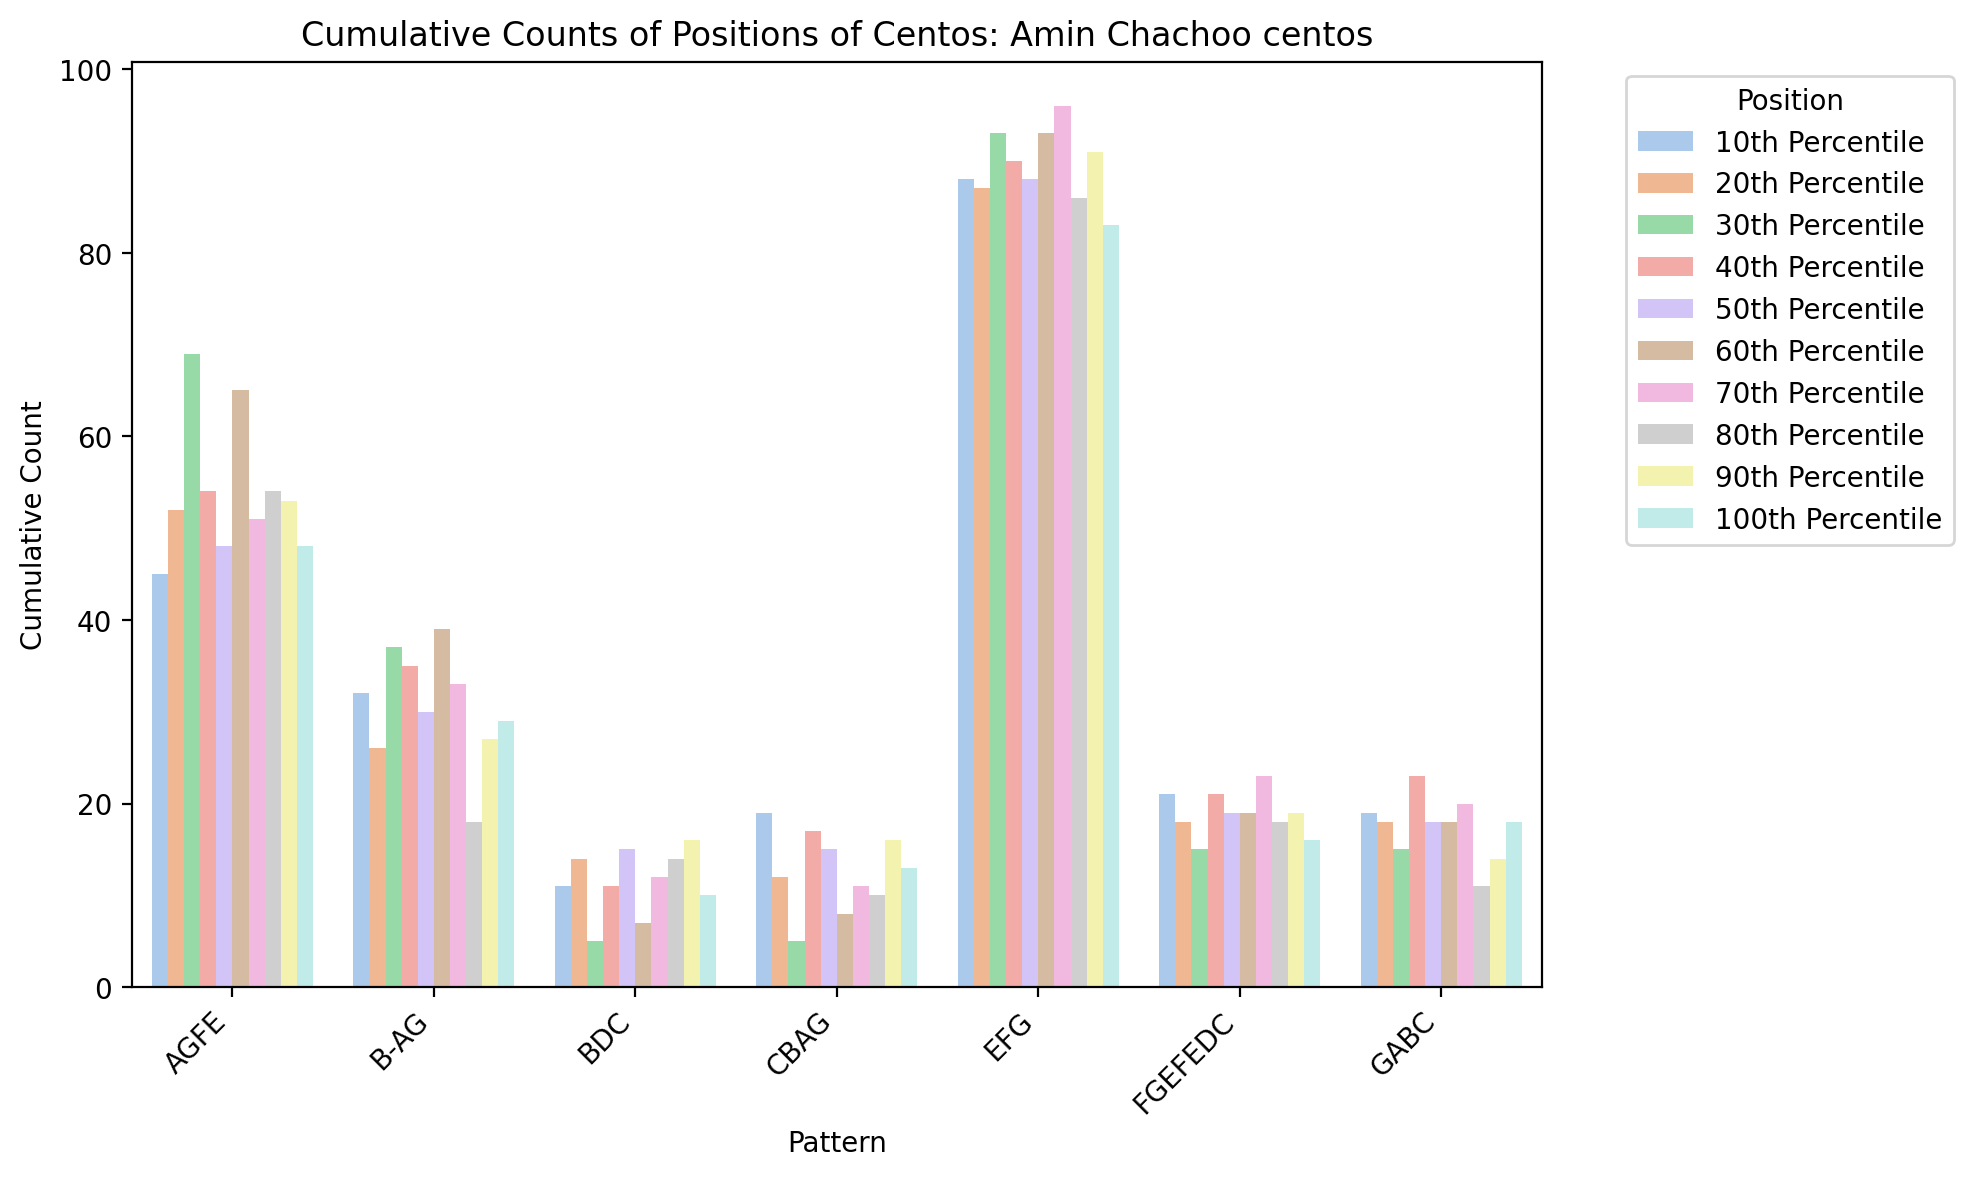

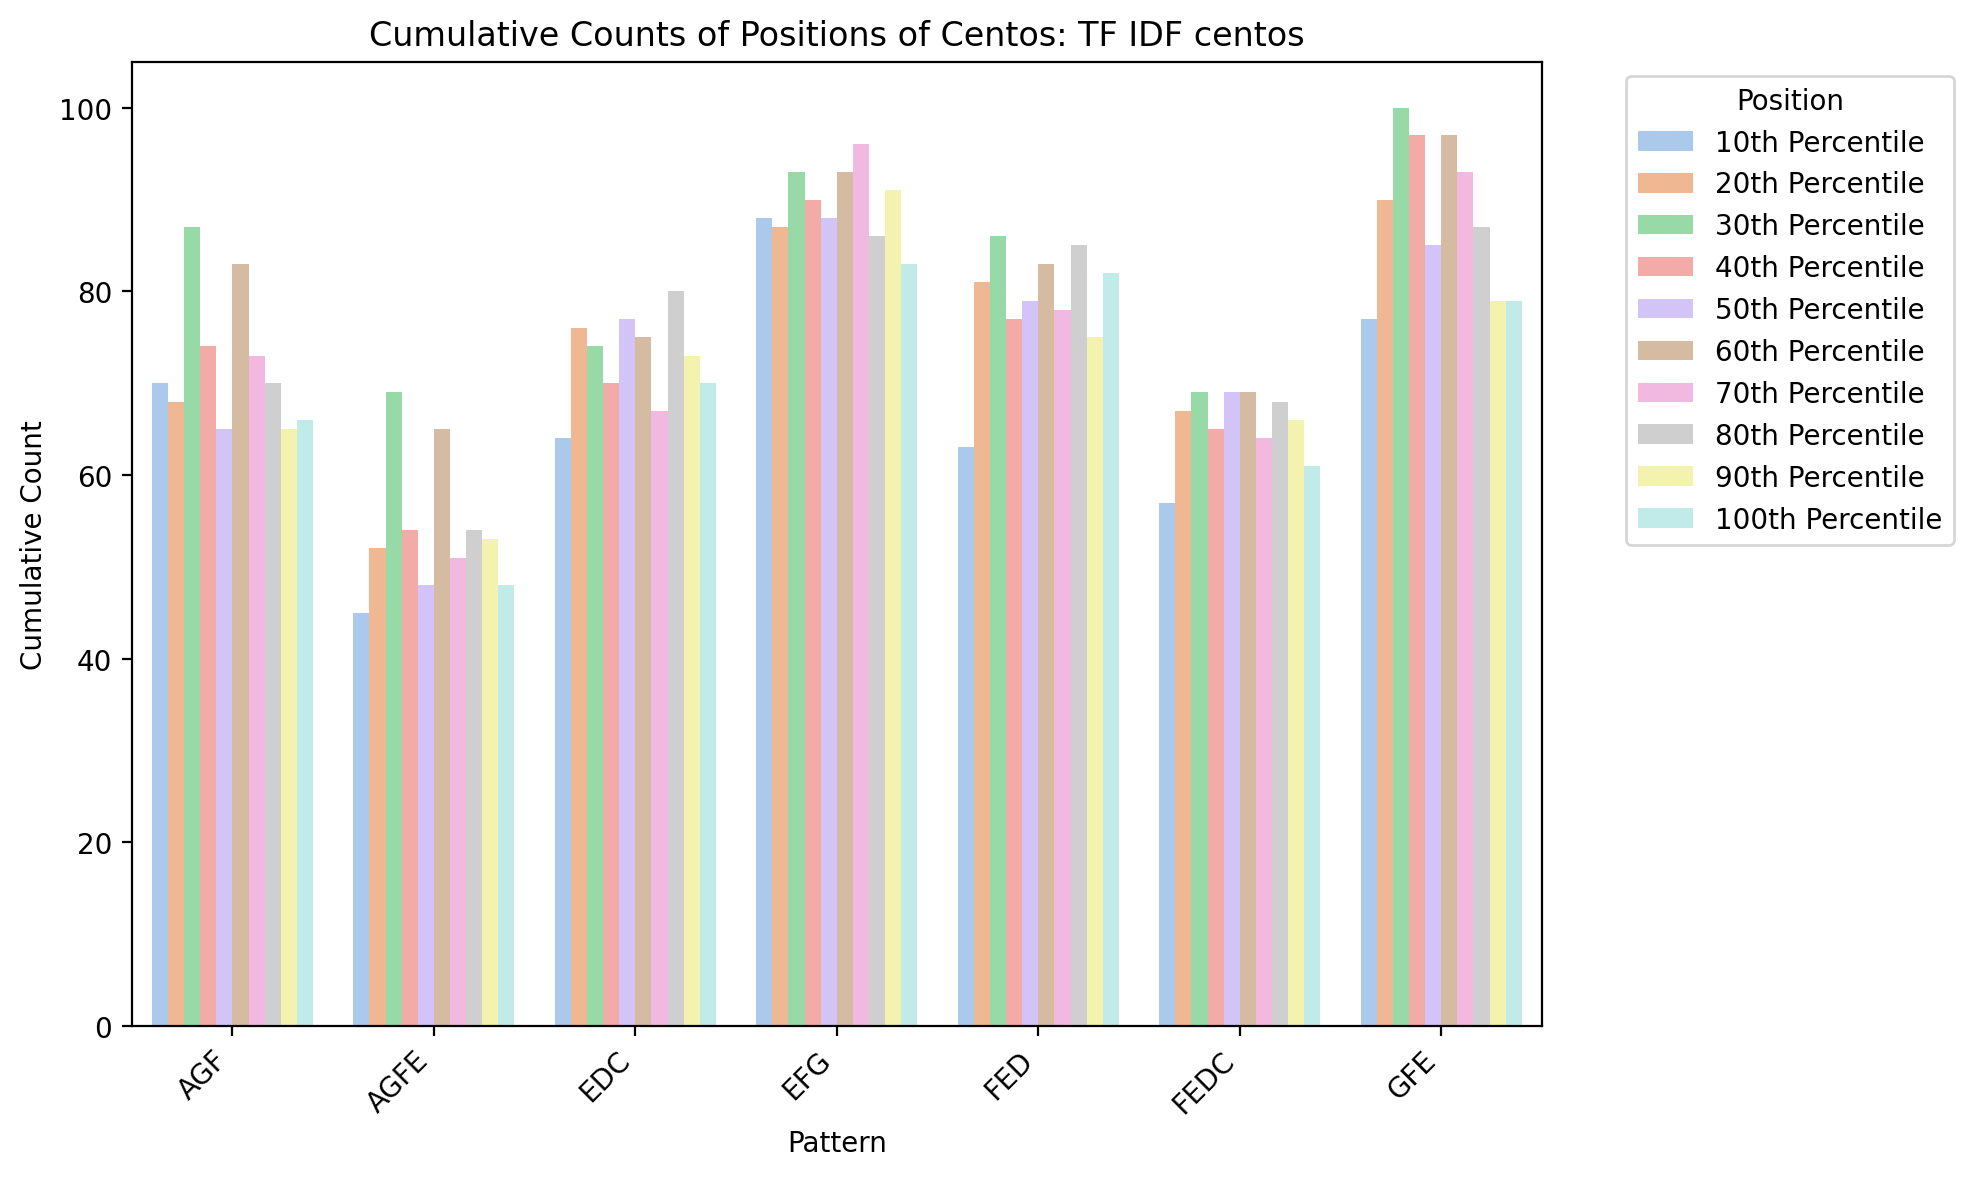

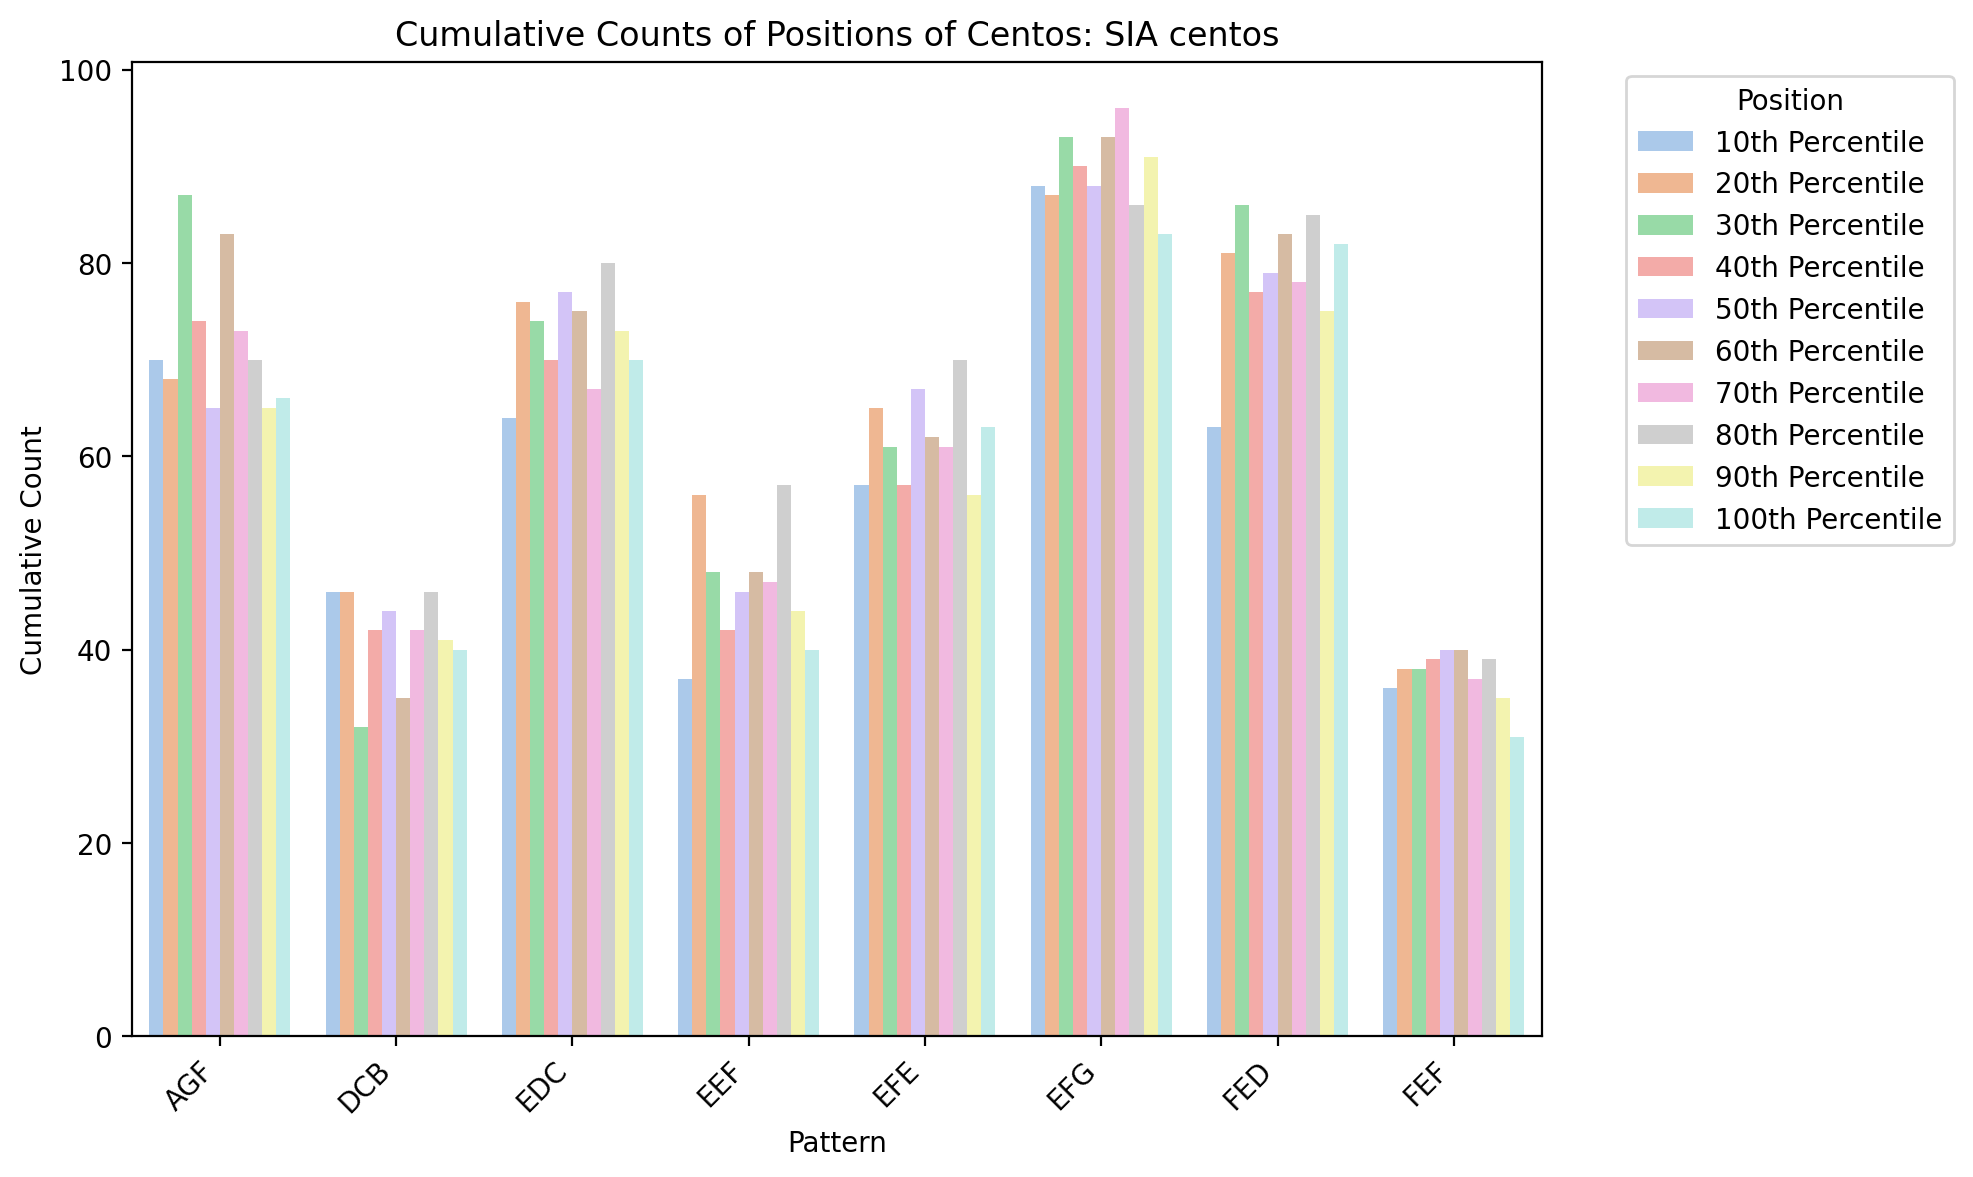

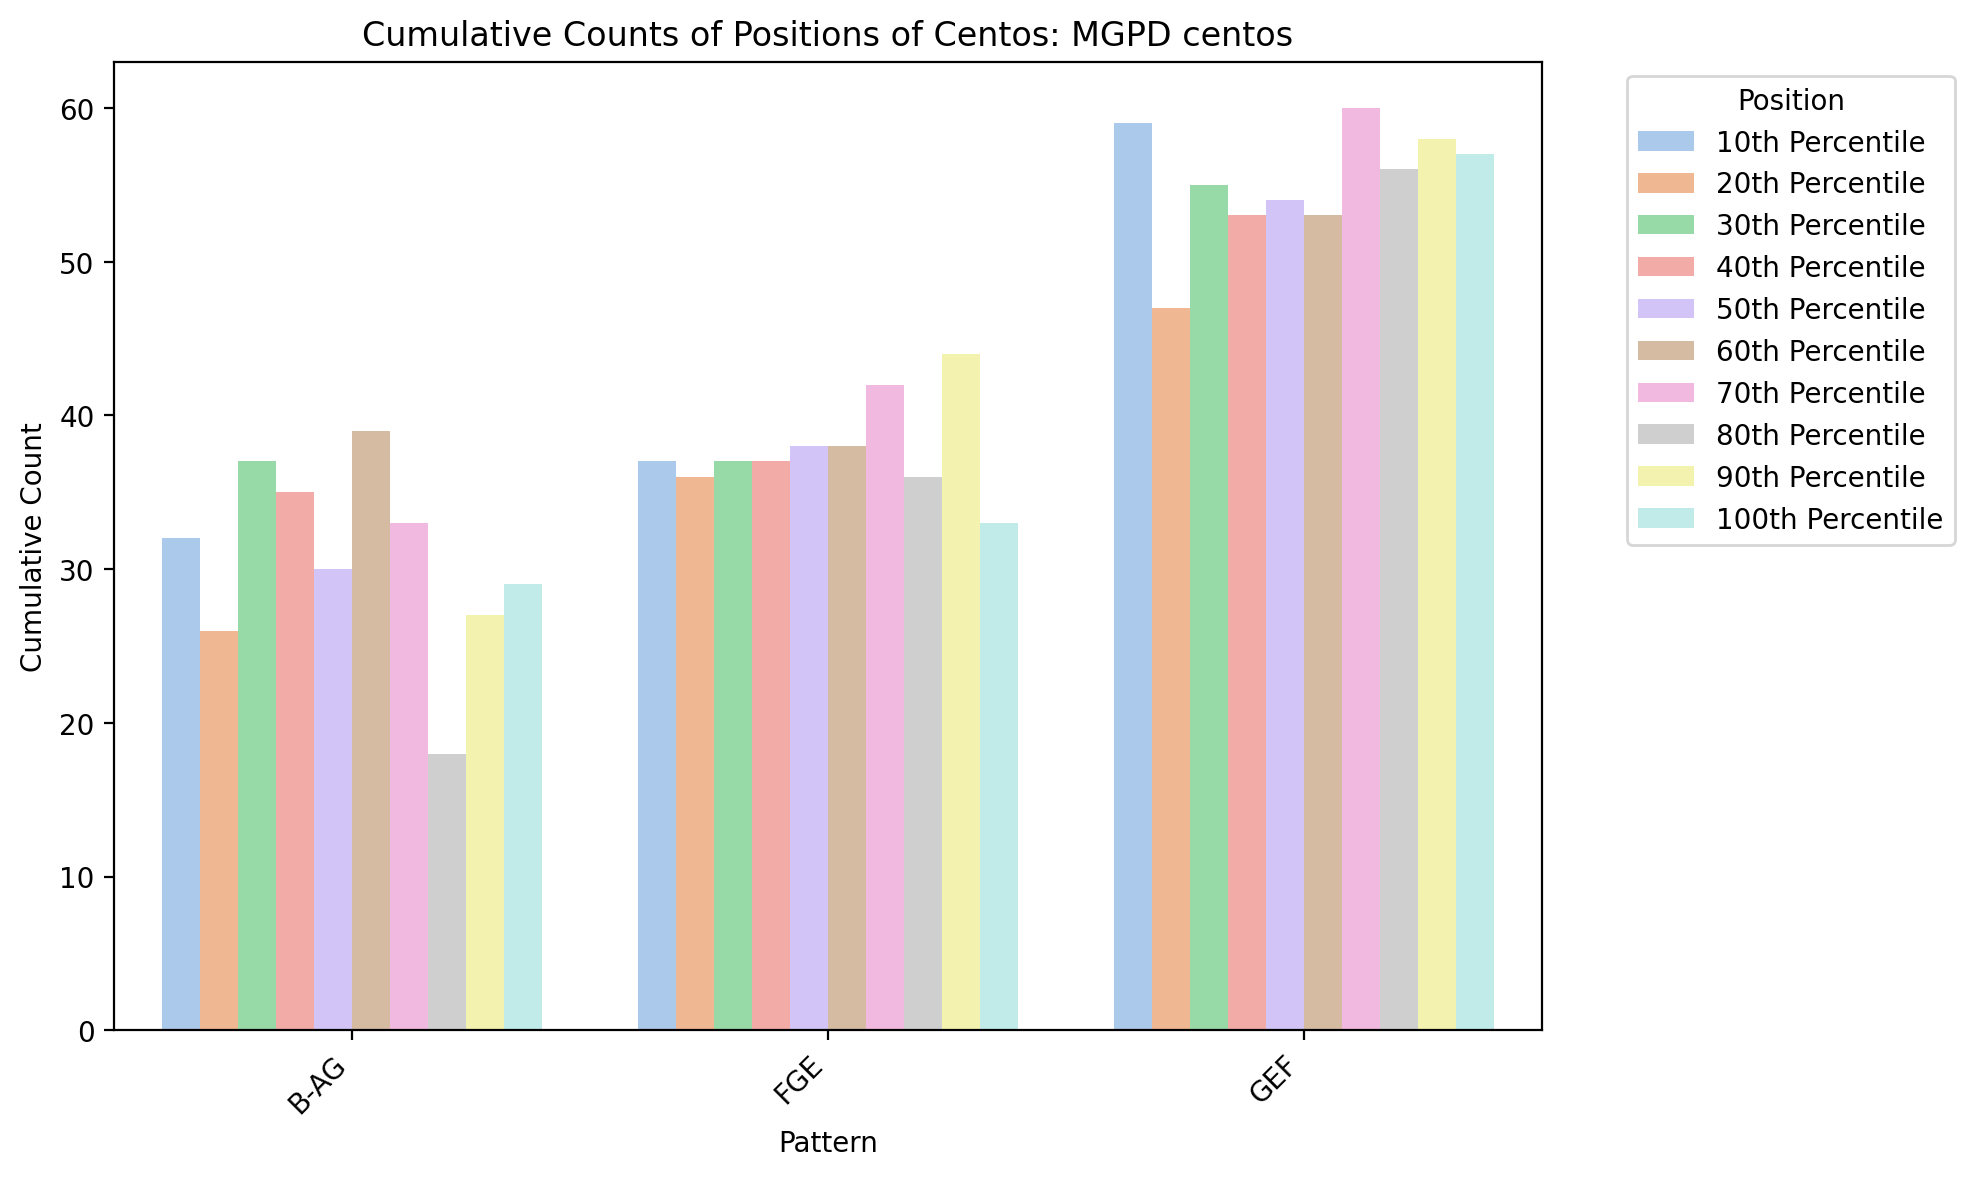

LINE LEVEL:


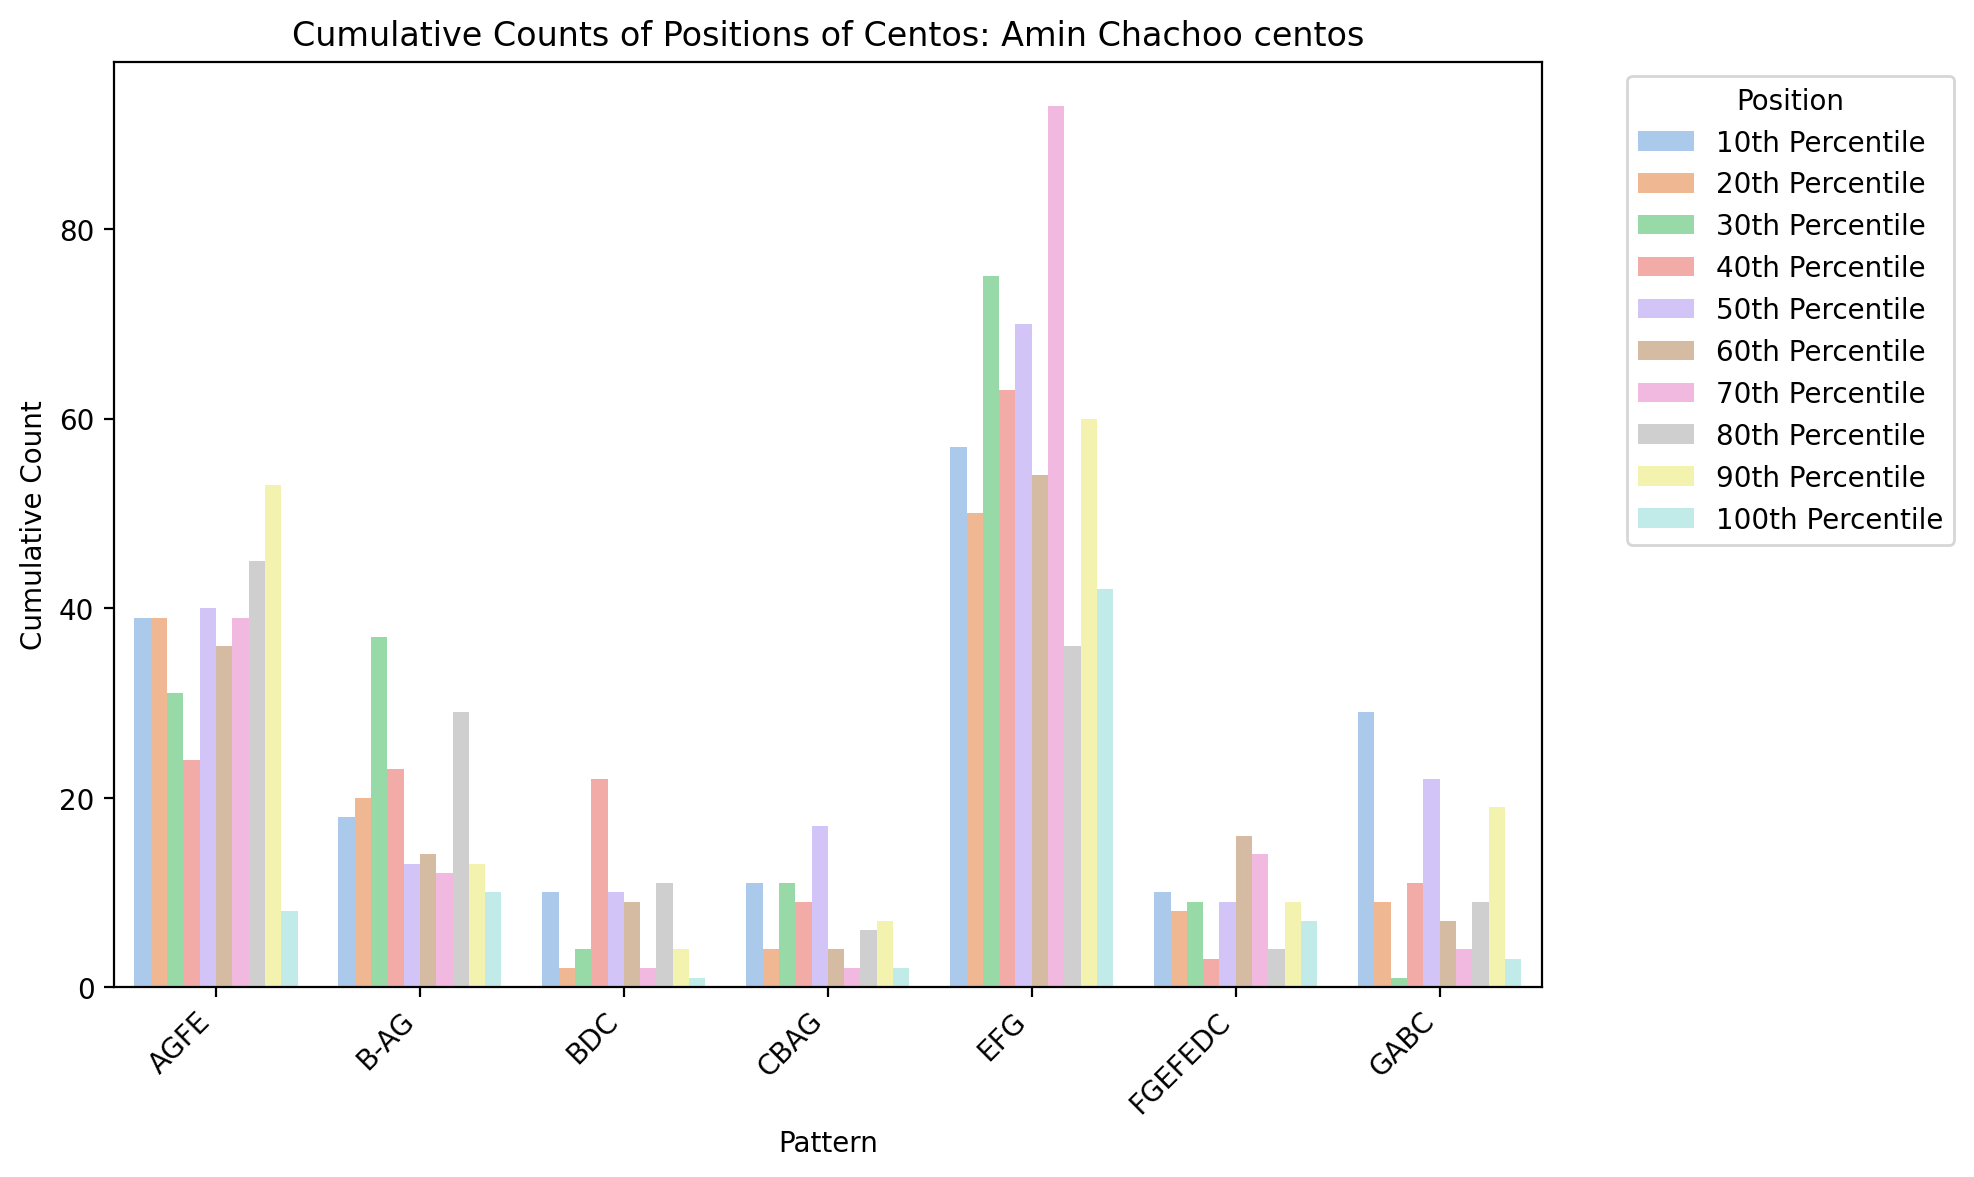

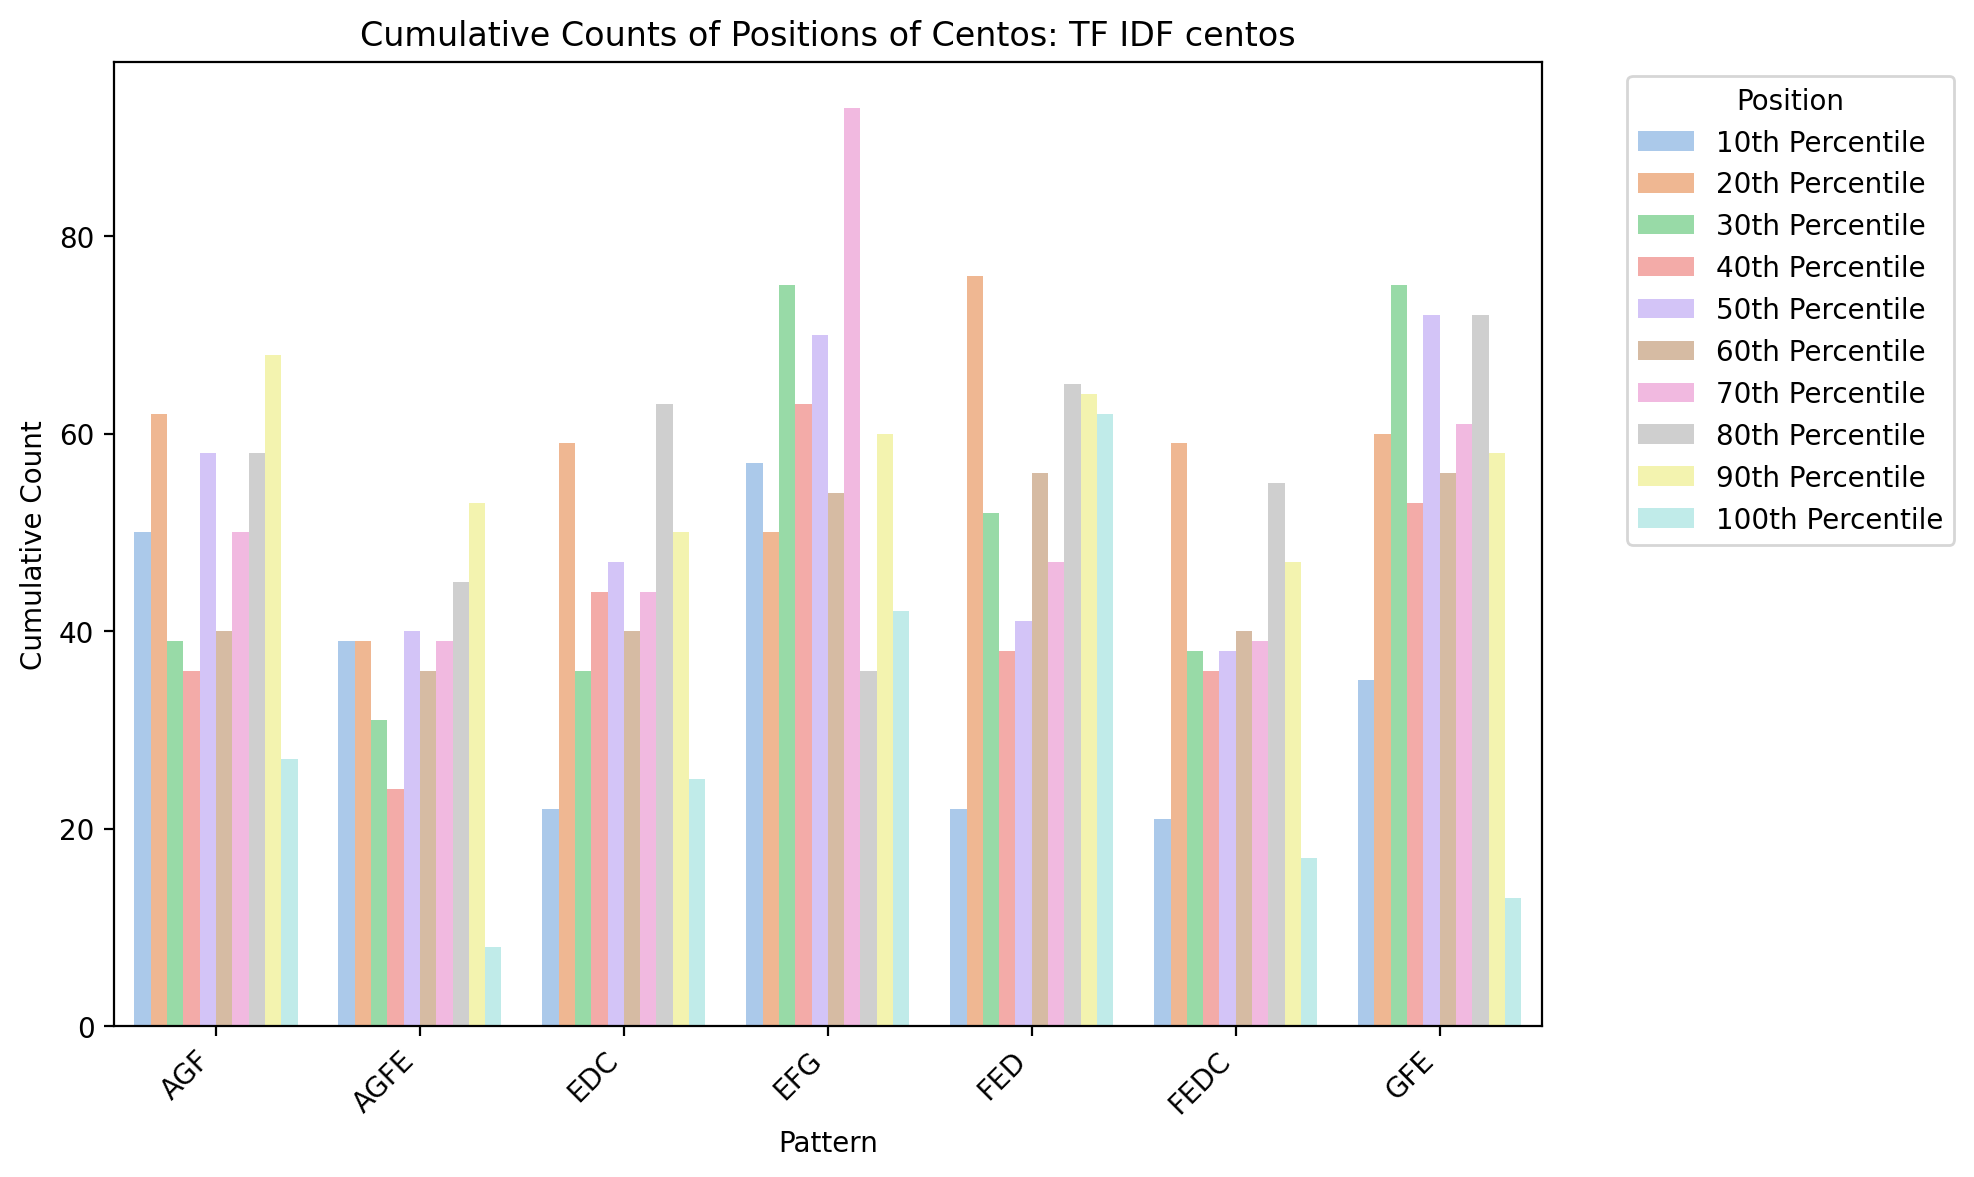

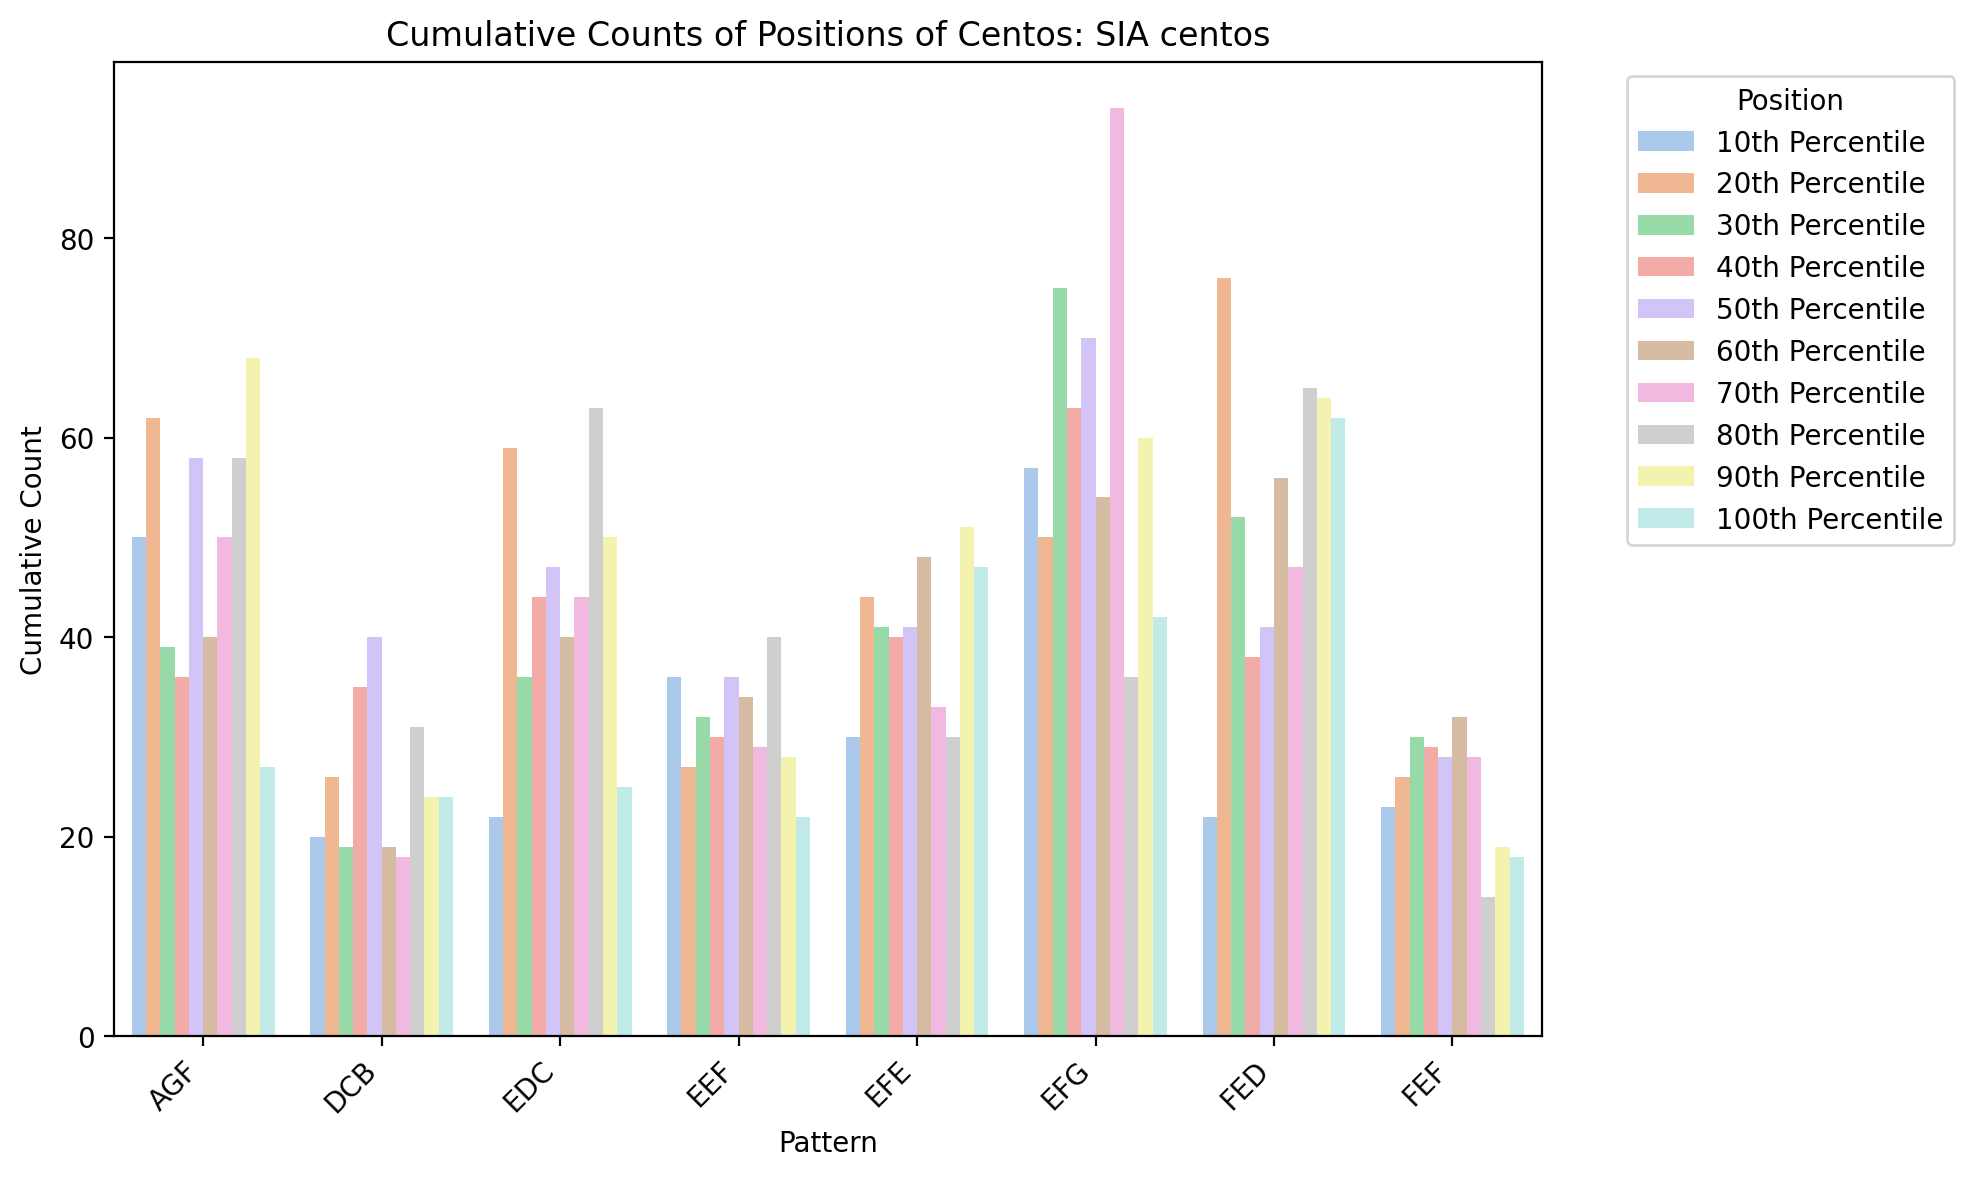

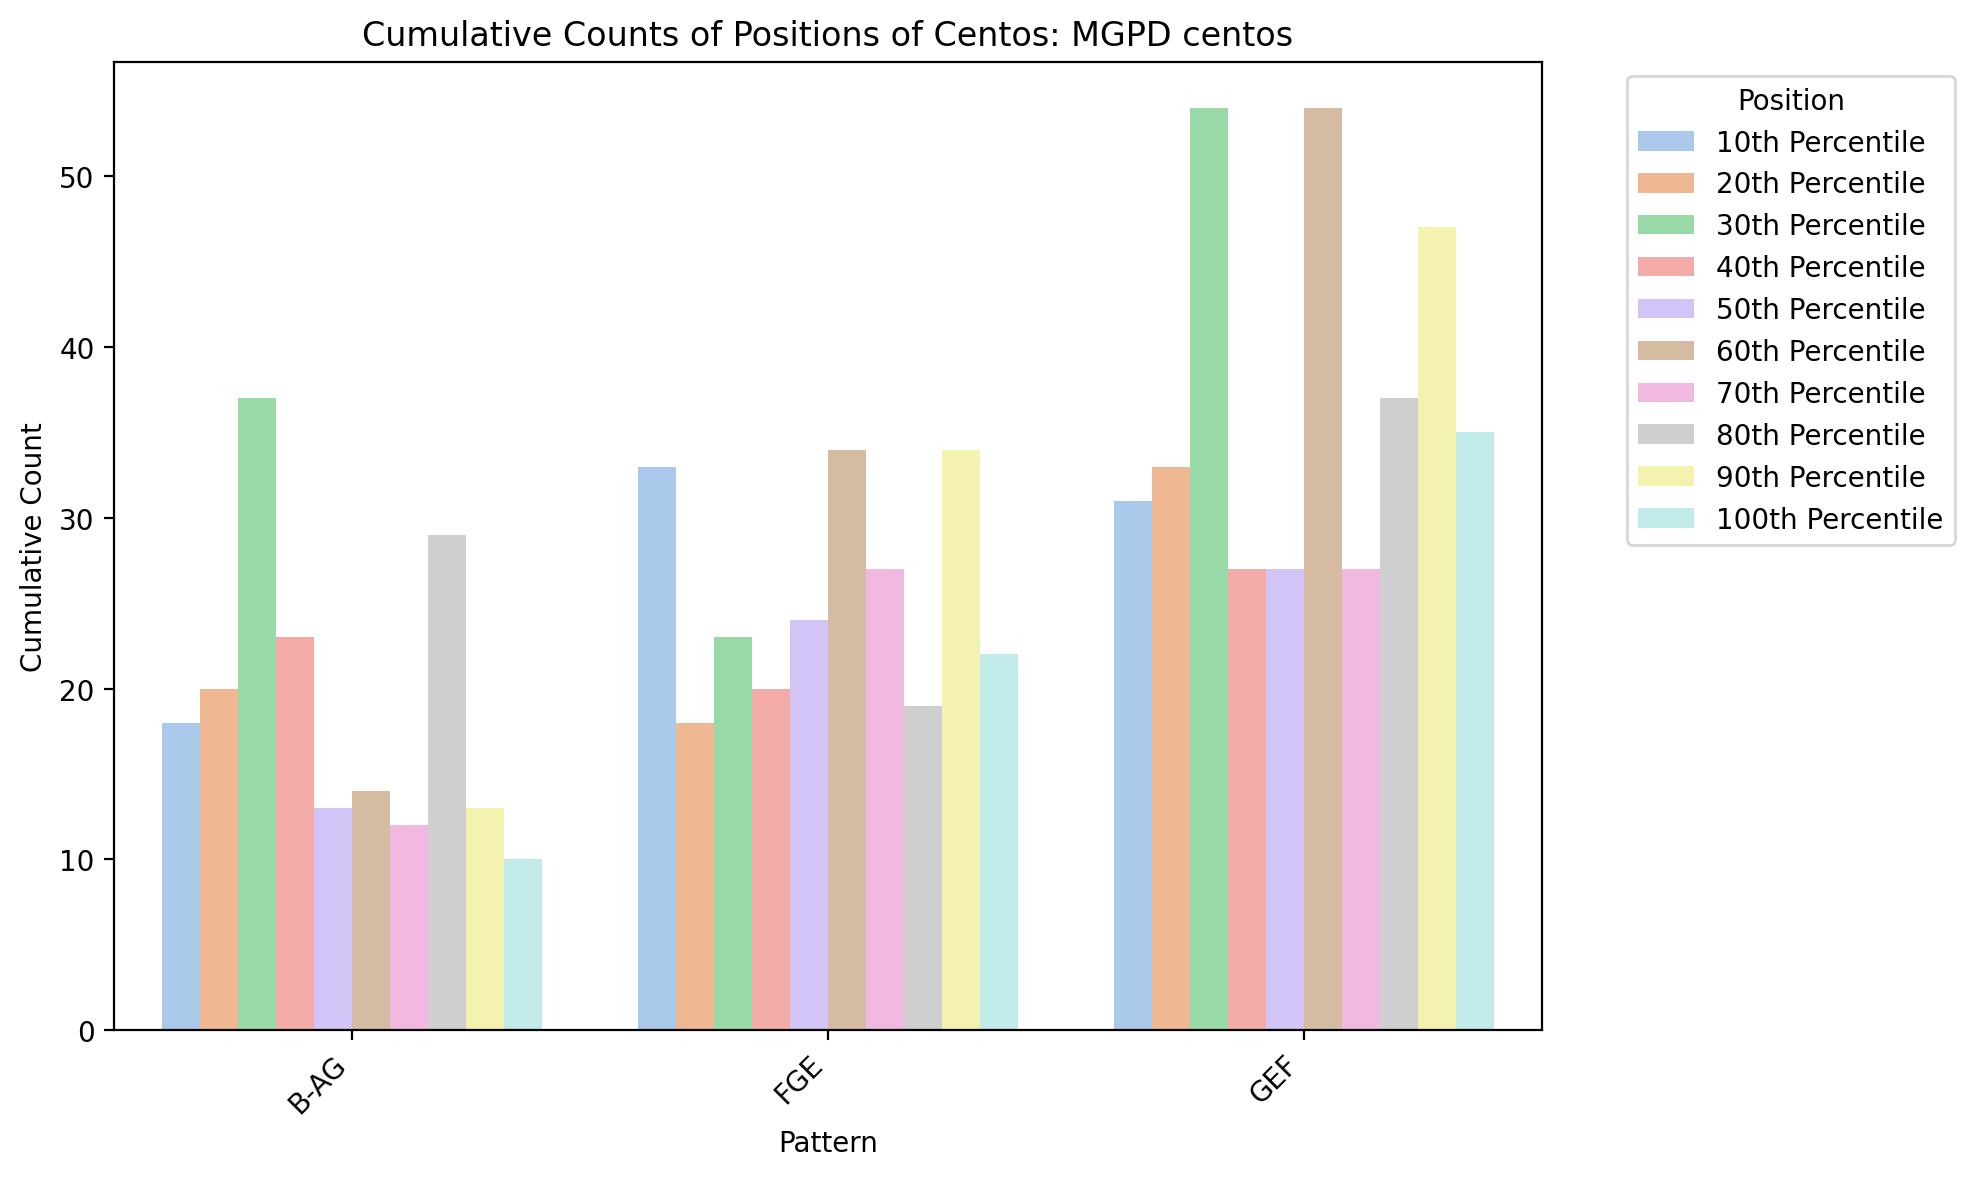

In [31]:
#plot distribution over centos lists 

if PLOT_ALL_DATA_DISTR_PER_CENTOS_LIST == True:
    
    print('DIVIDED INTO FIRST 25%, MIDDLE 50%, AND LAST 25%')
    print("SANAI LEVEL:")
    for centos_list in sanai_distribution_per_centos_list_3:
        plot.plot_centos_distribution(sanai_distribution_per_centos_list_3[centos_list], centos_list)

    print("LINE LEVEL:")
    for centos_list in lines_distribution_per_centos_list_3:
        plot.plot_centos_distribution(lines_distribution_per_centos_list_3[centos_list], centos_list)

    print('DIVIDED INTO INCREMENTS OF 10%')
    print("SANAI LEVEL:")
    for centos_list in sanai_distribution_per_centos_list_10:
        plot.plot_centos_distribution(sanai_distribution_per_centos_list_10[centos_list], centos_list)

    print("LINE LEVEL:")
    for centos_list in lines_distribution_per_centos_list_10:
        plot.plot_centos_distribution(lines_distribution_per_centos_list_10[centos_list], centos_list)

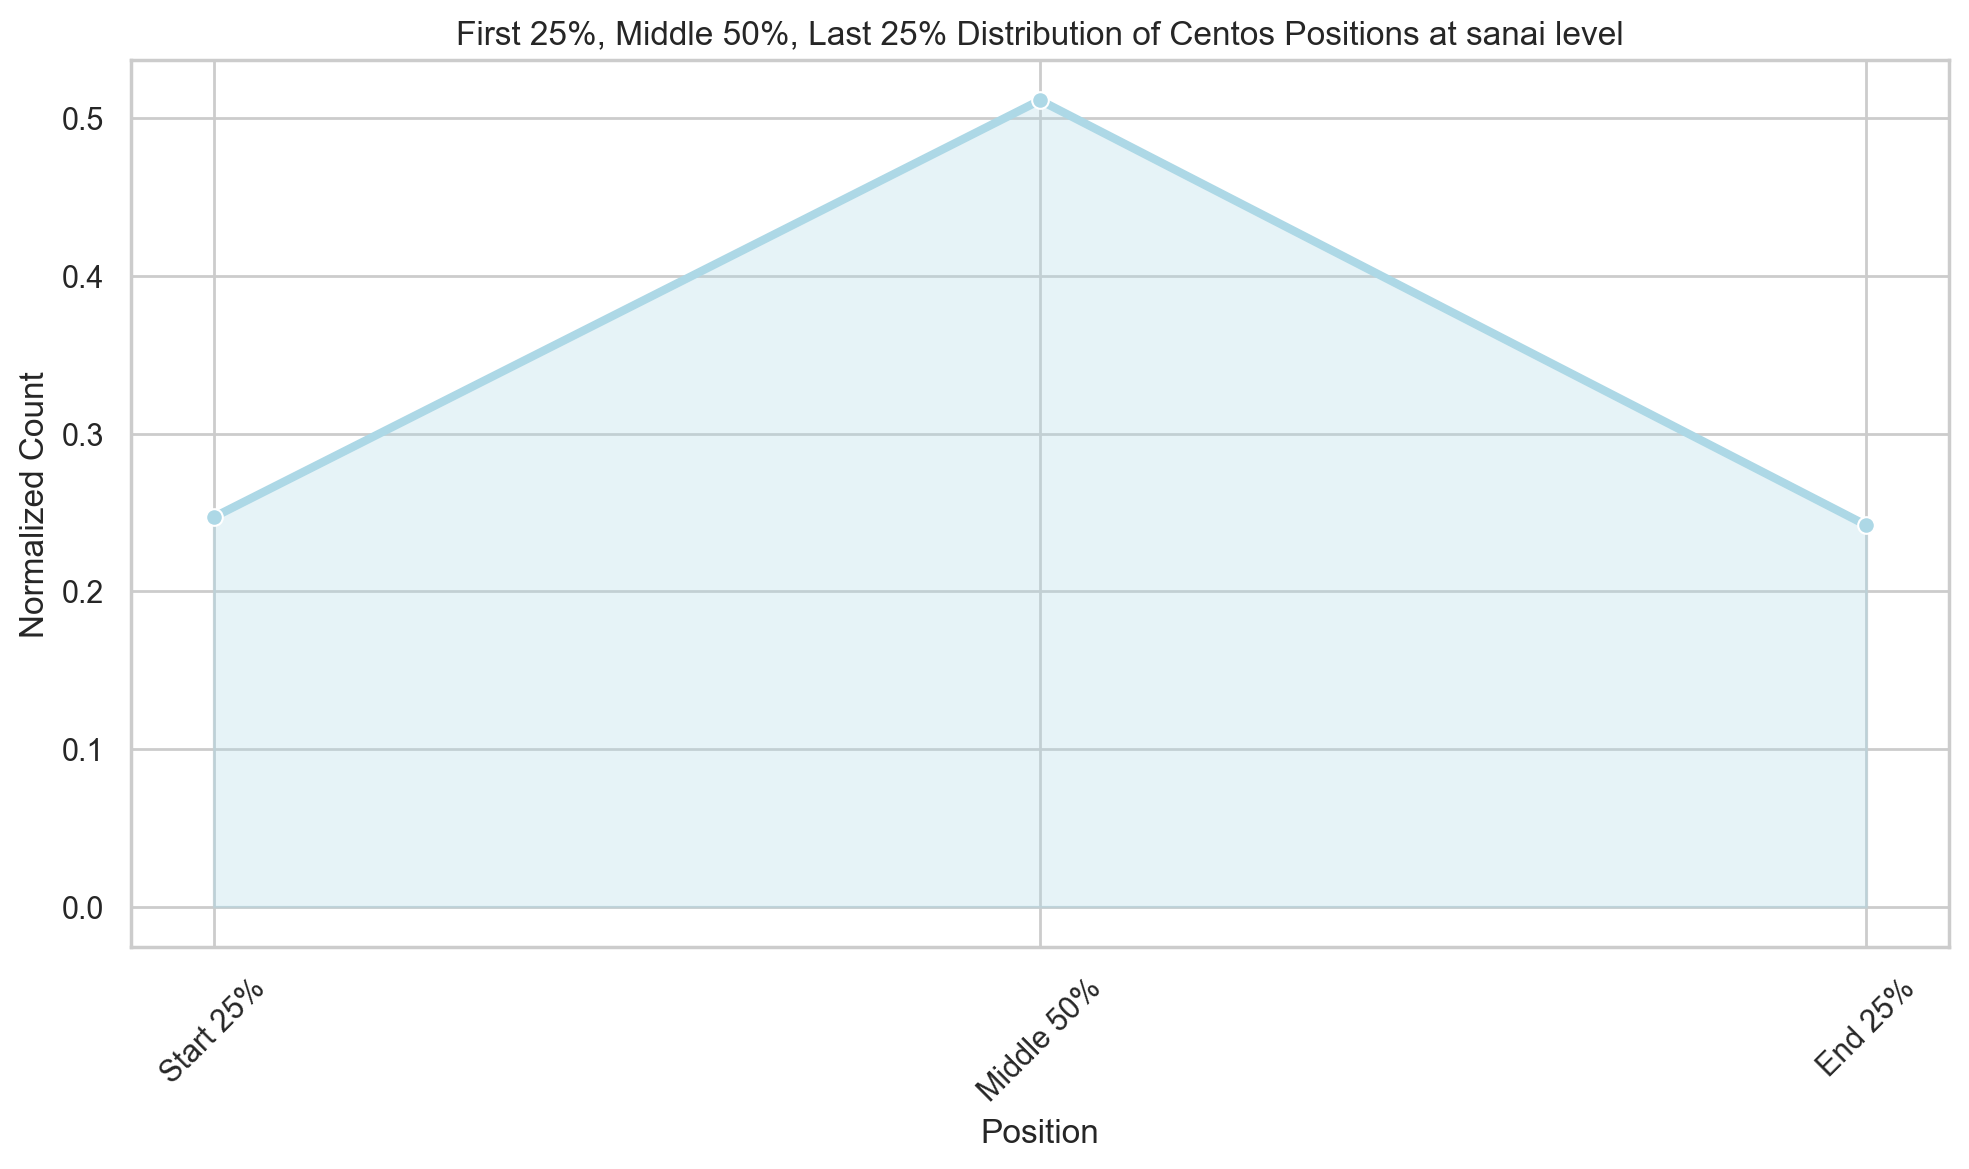

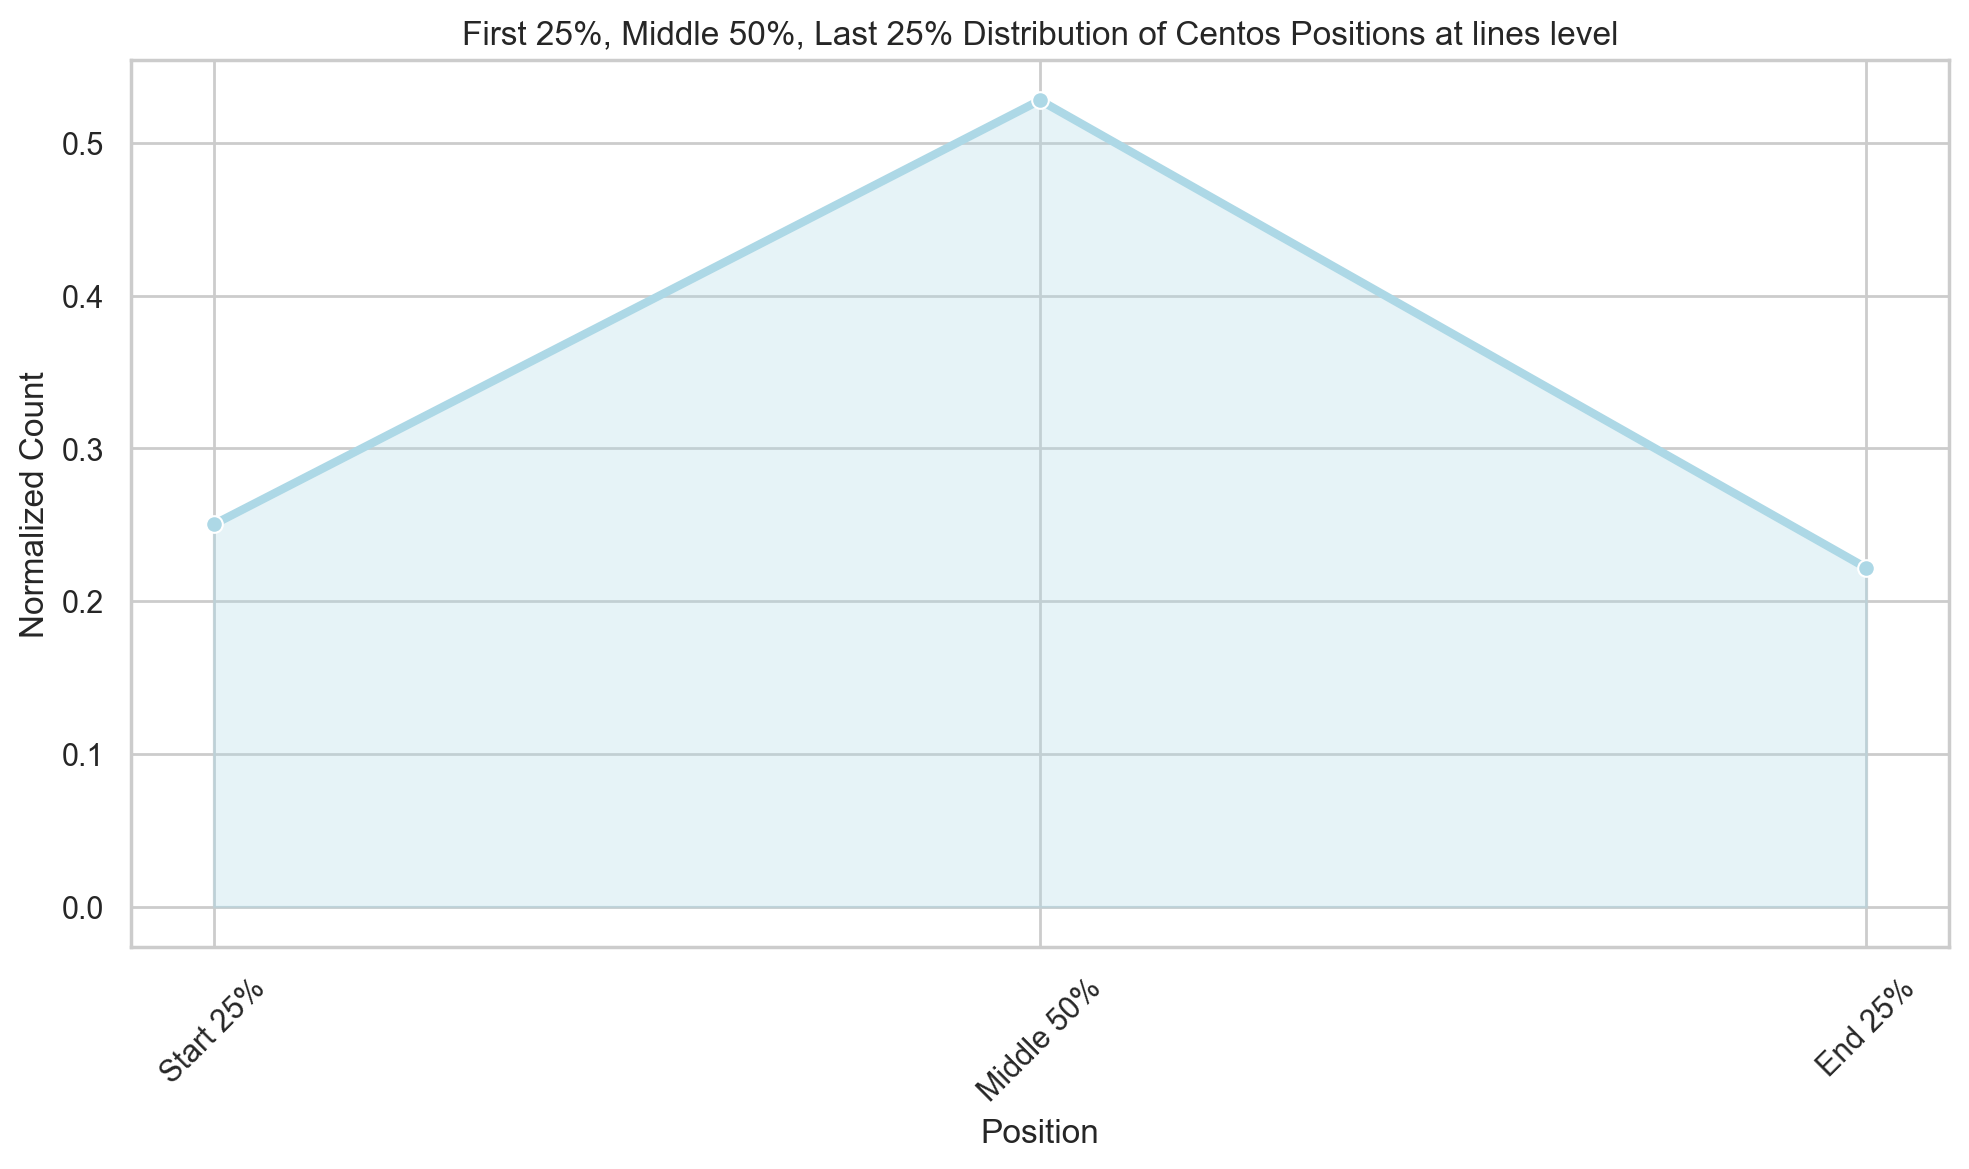

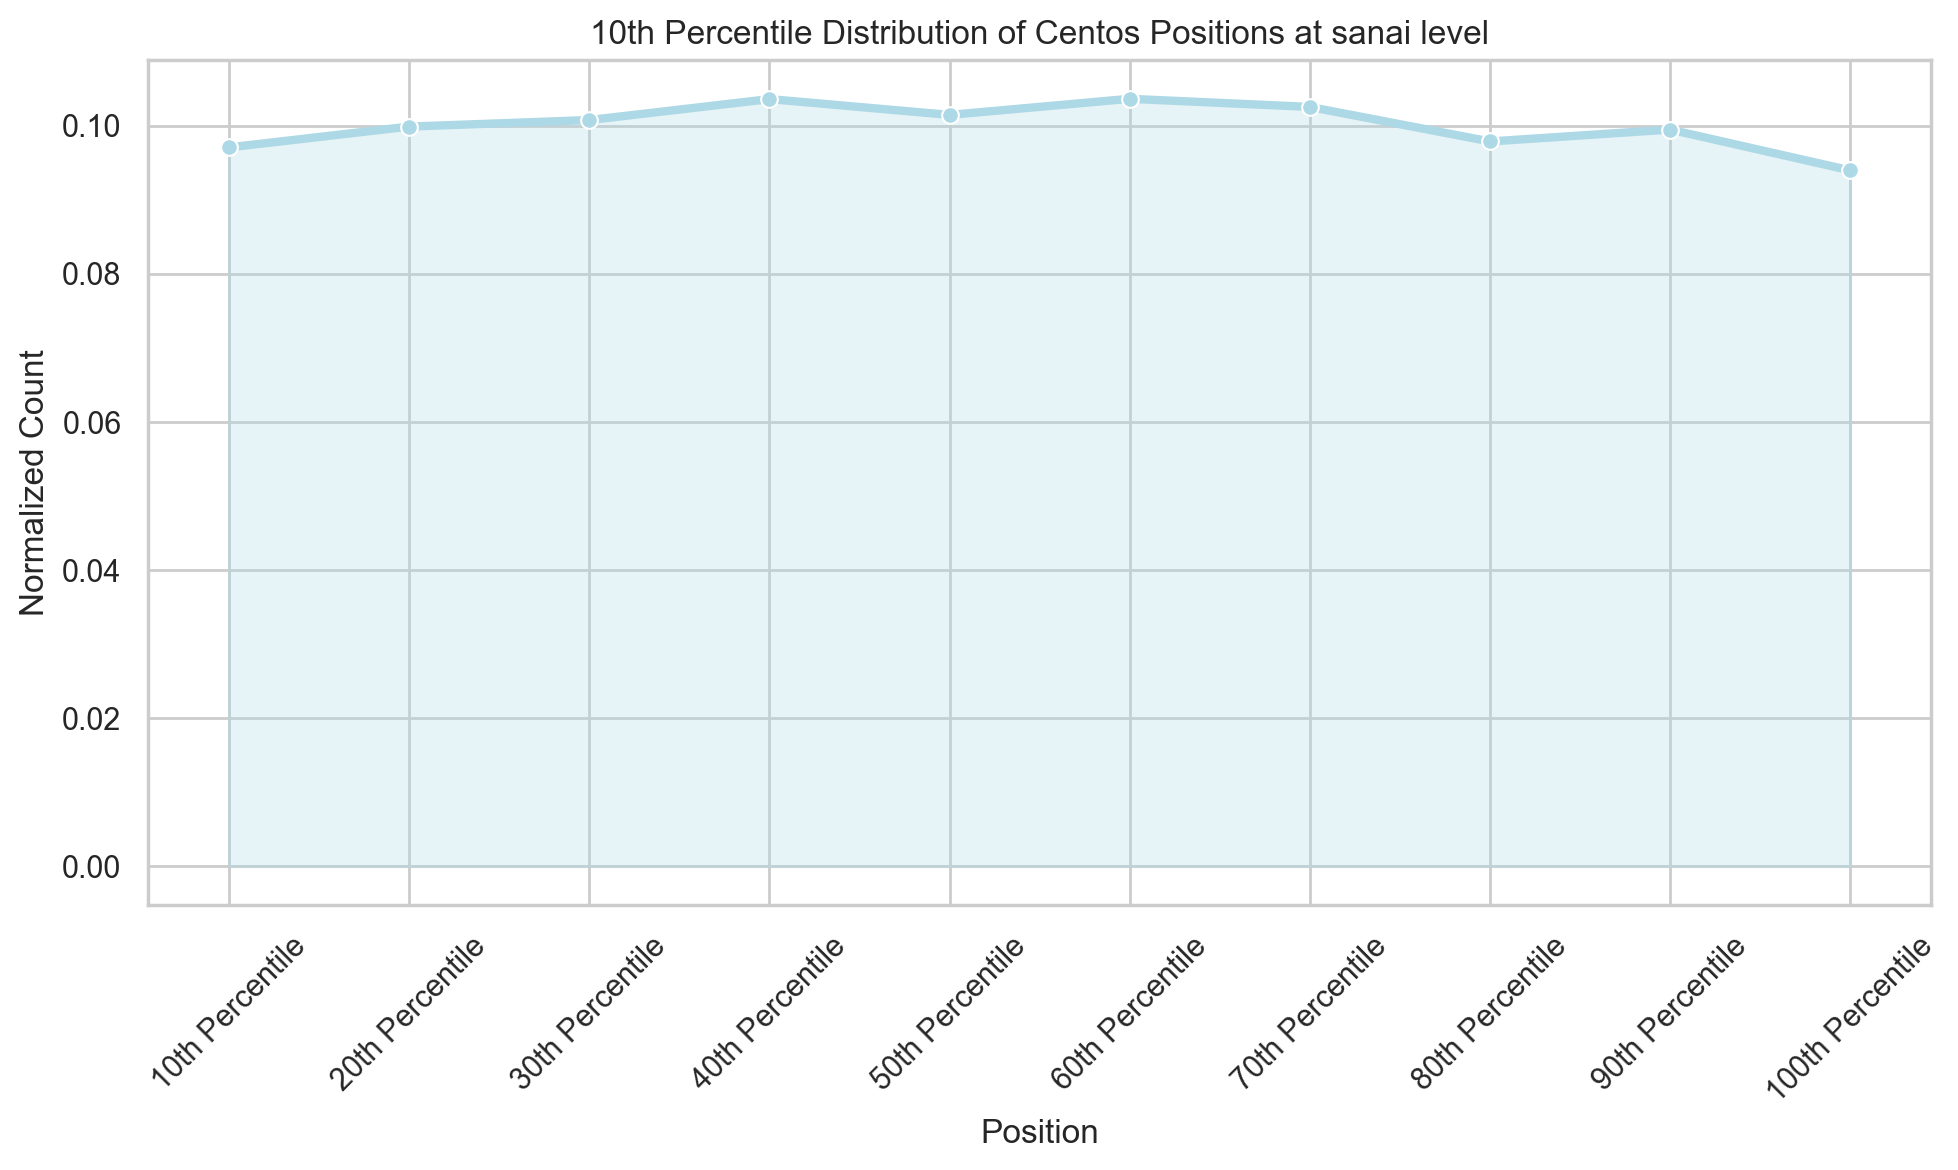

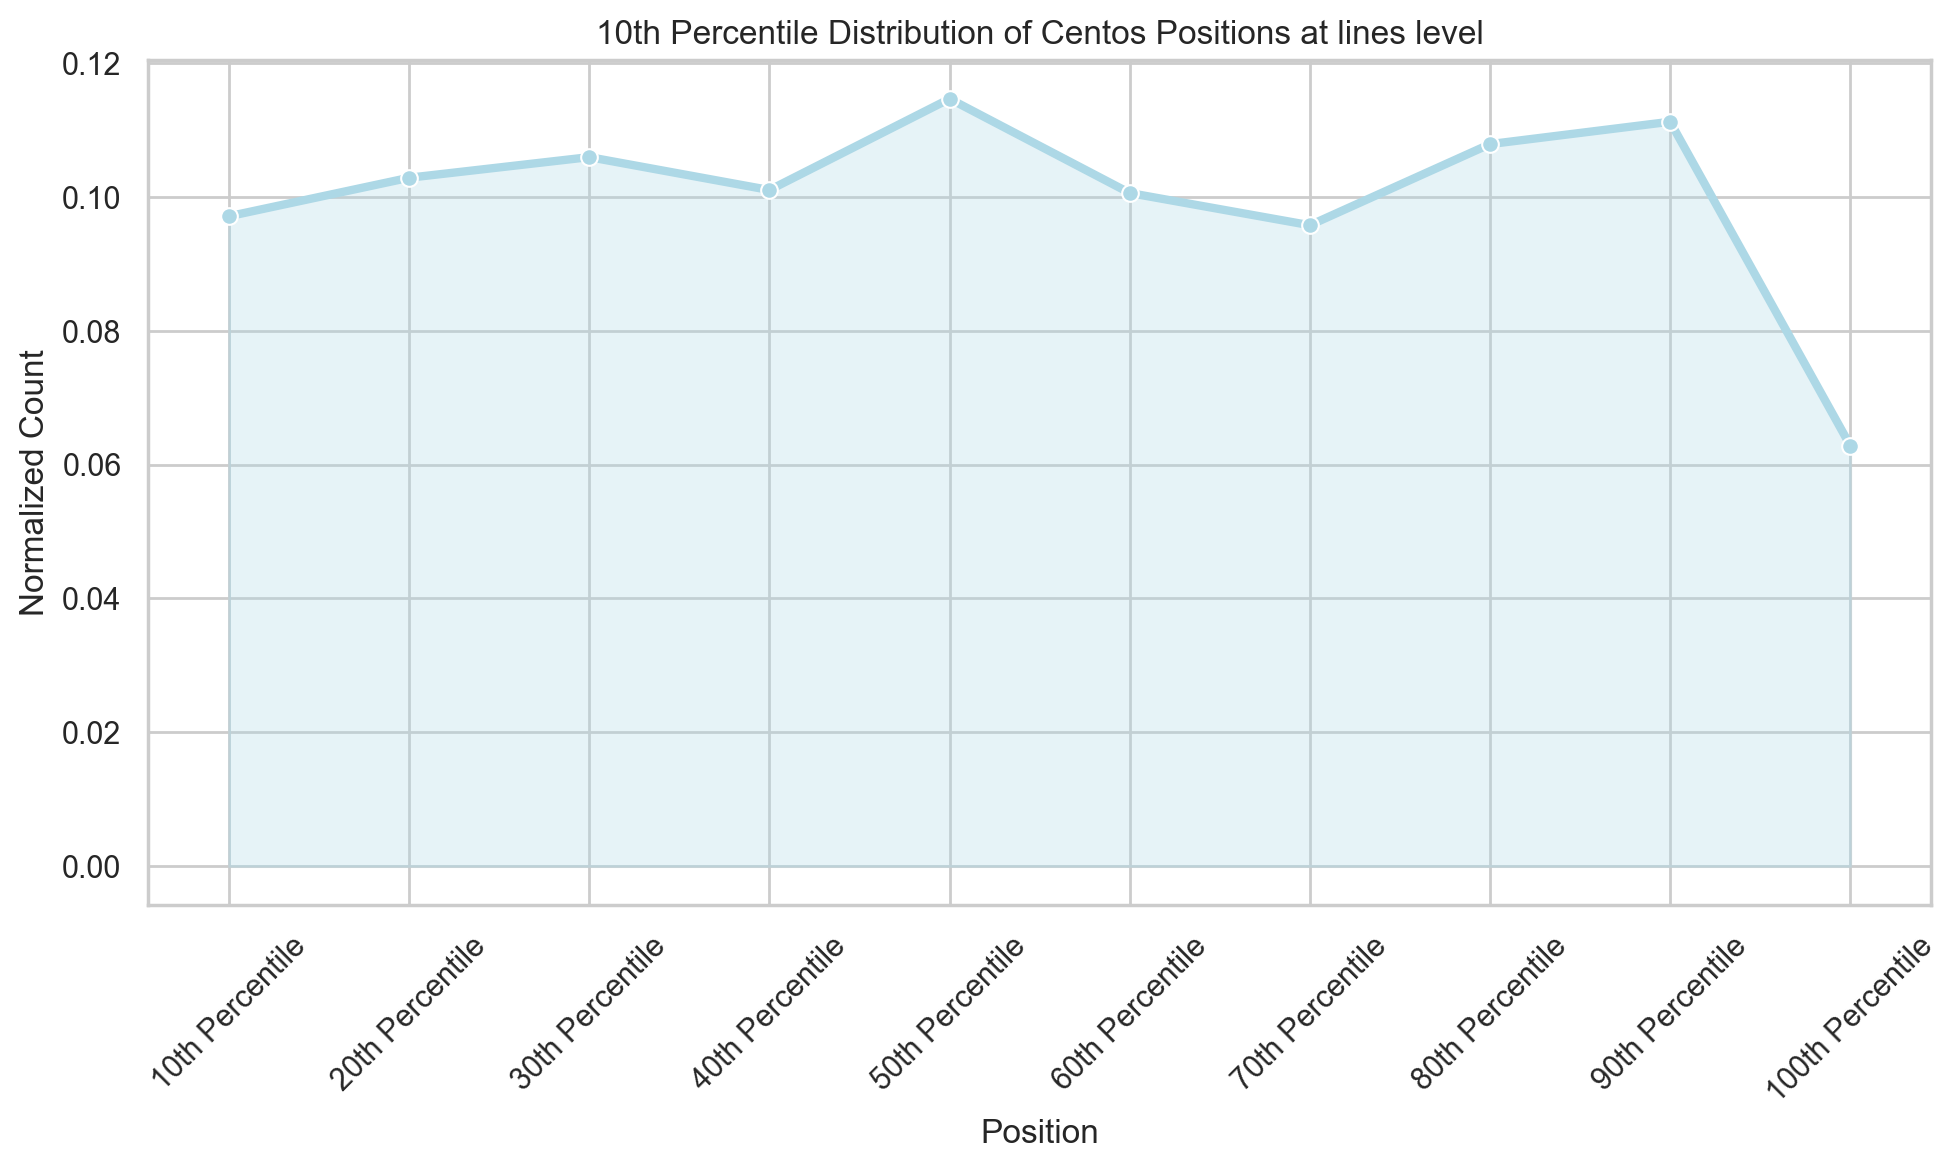

In [ ]:
#plot overall trend
if PLOT_OVERALL_TREND == True:
    plot.plot_complete_distribution_trend(sanai_combined_3, 'sanai', 'First 25%, Middle 50%, Last 25%')
    plot.plot_complete_distribution_trend(lines_combined_3, 'lines', 'First 25%, Middle 50%, Last 25%')

    plot.plot_complete_distribution_trend(sanai_combined_10, 'sanai', '10th Percentile')
    plot.plot_complete_distribution_trend(lines_combined_10, 'lines', '10th Percentile')

### 8. Calculate and display statistical significance

In [64]:
'''
Modify this flag to toggle between whether dataframes of statistical significance in all cases are displayed or not.
'''

DISPLAY_STAT_SIG = False

In [55]:
sanai_chi_sq_3 = {}
sanai_chi_sq_10 = {}
line_chi_sq_3 = {}
line_chi_sq_10 = {}

print("Pure Chi Squared")
print("SANAI LEVEL:")
for centos_list in sanai_distribution_per_centos_list_3:
    sanai_chi_sq_3[centos_list] = stats.chi_squared_test(sanai_distribution_per_centos_list_3[centos_list])
    if DISPLAY_STAT_SIG:
        display(sanai_chi_sq_3[centos_list].style)

for centos_list in sanai_distribution_per_centos_list_10:
    sanai_chi_sq_10[centos_list] = stats2.chi_squared_test_10(sanai_distribution_per_centos_list_10[centos_list])
    if DISPLAY_STAT_SIG:
        display(sanai_chi_sq_10[centos_list].style)

sanai_chi_sq_significance_3 = stats.count_significance(sanai_chi_sq_3)
sanai_chi_sq_significance_10 = stats.count_significance(sanai_chi_sq_10)
print('\n3 split')
display(sanai_chi_sq_significance_3.style)
print('\n10 split')
display(sanai_chi_sq_significance_10.style)

print("LINE LEVEL:")
for centos_list in lines_distribution_per_centos_list_3:
    line_chi_sq_3[centos_list] = stats.chi_squared_test(lines_distribution_per_centos_list_3[centos_list])
    if DISPLAY_STAT_SIG:
        display(line_chi_sq_3[centos_list].style)

for centos_list in lines_distribution_per_centos_list_10:
    line_chi_sq_10[centos_list] = stats2.chi_squared_test_10(lines_distribution_per_centos_list_10[centos_list])
    if DISPLAY_STAT_SIG:
        display(line_chi_sq_10[centos_list].style)

line_chi_sq_significance_3 = stats.count_significance(line_chi_sq_3)
line_chi_sq_significance_10 = stats.count_significance(line_chi_sq_10)
print('\n3 split')
display(line_chi_sq_significance_3.style)
print('\n10 split')
display(line_chi_sq_significance_10.style)

Pure Chi Squared
SANAI LEVEL:

3 split


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.000000
1,TF IDF centos,0.000000
2,SIA centos,0.000000
3,MGPD centos,0.000000



10 split


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.000000
1,TF IDF centos,0.000000
2,SIA centos,0.000000
3,MGPD centos,0.000000


LINE LEVEL:

3 split


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.000000
1,TF IDF centos,0.000000
2,SIA centos,0.000000
3,MGPD centos,0.000000



10 split


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.000000
1,TF IDF centos,0.000000
2,SIA centos,0.000000
3,MGPD centos,0.000000


As the chi-squared test suggests that the results are not statistically significant, further statistical tests were carried out for further analysis of the results.

In [71]:
sanai_mcnemar = {}
lines_mcnemar = {}

print("\nMcNemar Test")
print("SANAI LEVEL:")
for centos_list in sanai_distribution_per_centos_list_3:
    sanai_mcnemar[centos_list] = stats.mcnemar_test(sanai_distribution_per_centos_list_3[centos_list])
    if DISPLAY_STAT_SIG:
        display(sanai_mcnemar[centos_list].style)

sanai_mcnemar_significance = stats.count_significance(sanai_mcnemar)
display(sanai_mcnemar_significance.style)

print("\nLINE LEVEL:")
for centos_list in lines_distribution_per_centos_list_3:
    lines_mcnemar[centos_list] = stats.mcnemar_test(lines_distribution_per_centos_list_3[centos_list])
    if DISPLAY_STAT_SIG:
        display(lines_mcnemar[centos_list].style)

lines_mcnemar_significance = stats.count_significance(lines_mcnemar)
display(lines_mcnemar_significance.style)


McNemar Test
SANAI LEVEL:


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.857143
1,TF IDF centos,1.000000
2,SIA centos,1.000000
3,MGPD centos,1.000000



LINE LEVEL:


,Centos_List,Average_Significance
0,Amin Chachoo centos,0.857143
1,TF IDF centos,1.000000
2,SIA centos,1.000000
3,MGPD centos,1.000000


The above McNemar results for the 25%, 50%, 75% suggest significance. However, this may because the middle 50% is obviously overrepresented compared the first and last 25%. 

Mixed results from statistical tests such as the chi-squared test and McNemar's test can occur due to differences in their underlying assumptions and sensitivity to various aspects of the data. 

McNemar's test, designed for paired nominal data, is sensitive to small changes within pairs, making it suitable for analyzing subtle differences even with small sample sizes. Conversely, the chi-squared test examines independence between categorical variables more broadly, potentially missing significance in paired data if differences within pairs are insufficient to impact overall association. 

Analyzing smaller percentiles of a distribution can provide finer insights into nuanced changes within the data.

Let's try the Cochran's Q test on the 10% distribution.

In [78]:
sanai_cochrans_q = {}
lines_cochrans_q = {}

print("SANAI LEVEL:")
for centos_list in sanai_distribution_per_centos_list_10:
    res = stats2.cochrans_q_test(sanai_distribution_per_centos_list_10[centos_list])
    print(centos_list)
    display(res.style)
    sanai_cochrans_q[centos_list] = res

SANAI LEVEL:
Amin Chachoo centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


TF IDF centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


SIA centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


MGPD centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


In [79]:
print("\nLINE LEVEL:")
for centos_list in lines_distribution_per_centos_list_10:
    res = stats2.cochrans_q_test(lines_distribution_per_centos_list_10[centos_list])
    print(centos_list)
    display(res.style)
    lines_cochrans_q[centos_list] = res


LINE LEVEL:
Amin Chachoo centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


TF IDF centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


SIA centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


MGPD centos


,q_stat,pvalue,deg_f,Significance
0,9.000000,0.437274,9,False


The Cochran's Q test is significant if p-value < significance_val.